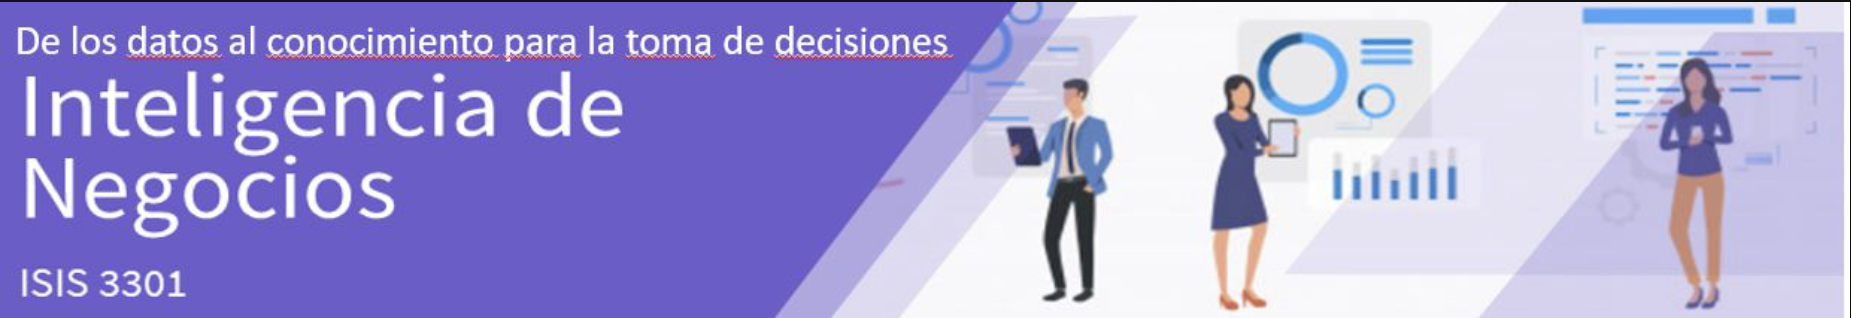

# Elegibilidad de un Paciente para Ensayos Clinicos de Cancer

## 1. Contexto
Los ensayos clínicos de cáncer intervencionista suelen ser demasiado restrictivos, y algunos pacientes suelen ser excluidos en función de la comorbilidad, los tratamientos previos o concomitantes, o el hecho de que son mayores de cierta edad. La eficacia y seguridad de nuevos tratamientos para pacientes de estas características no están, por tanto, definidas. En este trabajo, construimos un modelo para predecir automáticamente si las declaraciones clínicas breves se consideraron criterios de inclusión o exclusión. Usamos protocolos de ensayos clínicos de cáncer que estaban disponibles en https://www.kaggle.com/datasets/auriml/eligibilityforcancerclinicaltrials

## 2. Contenido

De acuerdo con la fuente de donde se extrajeron los datos (_Kaggle_), se extrajo un total de 6 186 572 declaraciones clínicas etiquetadas de 49 201 protocolos de TC intervencionistas sobre el cáncer (la URL para descargar este conjunto de datos está disponible gratuitamente en https://clinicaltrials.gov/ct2/results?term=neoplasmtype=Intrshowdow). Cada CT descargado es un archivo XML que sigue una estructura de campos definida por un esquema XML de ensayos clínicos. Los datos relevantes para este proyecto se derivan de los campos de intervención, condición y elegibilidad escritos en lenguaje de texto libre no estructurado.

Sin embargo, los datos con los que se cuentan para este proyecto son 12000, cada uno dividido en dos columnas: 
- Por un lado la columna de etiqueta: una etiqueta 0 (<code>label0</code>) si el paciente es elegible y etiqueta 1 (<code>label1</code>) si el paciente no es elegible.
- Por el otro lado la columna de texto sobre el estudio y la condicion, donde antes del punto se puede encontrar datos sobre el estudio y después del punto datos sobre el tipo de cáncer.

## 3. Comprension del Negocio y Enfoque Analitico

Una vez entendidos los datos y el contexto del problema, se plantea que el objetivo que se esta buscando con el analisis de _Machine Learning_, es determinar la elegibilidad de un paciente para ensayos clínicos de cáncer a partir del texto descriptivo, esto se debe a que se busca optimizar y acompañar el programa de selección de los pacientes, de forma que se ayude a determinar ciertos criterios que ayuden a definir la eficacia y seguridad de nuevos tratamientos para pacientes de estas características. 

Por lo tanto, se plantea que este es un problema de aprendizaje supervisado y de clasificacion. Esto se debe a que ya de por si los datos están etiquetados, lo que permite hacer el entrenamiento más fácil y eficiente, y por el otro lado, es un problema de clasificación binaria, pues vamos a definir si es el paciente es elegible o no.

## 4. Perfilamiento y Entendimiento de los Datos

A continuacion, se hace una carga inicial de los datos, y se hace un análisis de la calidad de los datos.

### 4.1. Carga de los datos

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

import warnings
warnings.filterwarnings("ignore")

import contractions
import inflect
import re, string, unicodedata
# from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Importamos la librería necesaria para los modelos:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree

from sklearn import metrics 

from sklearn.metrics import plot_confusion_matrix
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lrodr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lrodr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lrodr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
# df_tracks=pd.read_csv('data/202210_Lab2_BancAlpes_CC_data.csv', sep=',', encoding = 'utf-8', index_col=0)
df_tracks=pd.read_csv('clinical_trials_on_cancer_data_clasificacion.csv')

In [38]:
df_tracks

label                                study_and_condition
0      __label__0  study interventions are Saracatinib . recurren...
1      __label__1  study interventions are Stem cell transplantat...
2      __label__0  study interventions are Lenograstim . recurren...
3      __label__0  study interventions are Doxorubicin . stage ii...
4      __label__1  study interventions are Poly I-C . prostate ca...
...           ...                                                ...
11995  __label__0  study interventions are Prednisolone hemisucci...
11996  __label__0  study interventions are Bevacizumab . recurren...
11997  __label__1  study interventions are Antibodies, Monoclonal...
11998  __label__0  study interventions are Vorinostat . colorecta...
11999  __label__0  study interventions are Freund's Adjuvant . ov...

[12000 rows x 2 columns]

### 4.2. Indentificacion de Datos Nulos

Como se puede ver a continuacion, de los 12000 datos que hay, no hay ningun valor nulo en ninguna de las dos columnas.

In [39]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   label                12000 non-null  object
 1   study_and_condition  12000 non-null  object
dtypes: object(2)
memory usage: 187.6+ KB


### 4.3. Division de los datos en las columnas Study y Cancer_Type

Como los datos poseen informacion separada por un punto, se va a hacer una division de estos datos, para tener un poco mas de granularidad al momento de trabajar el problema.

In [40]:
df_tracks[["study", "cancer_type"]] = df_tracks["study_and_condition"].str.split(".", n = 1, expand = True)
df_tracks=df_tracks.drop(['study_and_condition'], axis=1)
df_tracks.head()

label                                              study  \
0  __label__0               study interventions are Saracatinib    
1  __label__1  study interventions are Stem cell transplantat...   
2  __label__0               study interventions are Lenograstim    
3  __label__0               study interventions are Doxorubicin    
4  __label__1                  study interventions are Poly I-C    

                                         cancer_type  
0   recurrent verrucous carcinoma of the larynx d...  
1   hodgkin lymphoma diagnosis and history of con...  
2   recurrent adult diffuse mixed cell lymphoma d...  
3   stage iii diffuse large cell lymphoma diagnos...  
4   prostate cancer diagnosis and unresolved irae...

Ahora se acomodara la columna <code>label</code>, de forma que solo sea o 0 o 1.

In [41]:
df_tracks['label']=df_tracks['label'].str.extract('(\d)', expand=True)
df_tracks.head()

label                                              study  \
0     0               study interventions are Saracatinib    
1     1  study interventions are Stem cell transplantat...   
2     0               study interventions are Lenograstim    
3     0               study interventions are Doxorubicin    
4     1                  study interventions are Poly I-C    

                                         cancer_type  
0   recurrent verrucous carcinoma of the larynx d...  
1   hodgkin lymphoma diagnosis and history of con...  
2   recurrent adult diffuse mixed cell lymphoma d...  
3   stage iii diffuse large cell lymphoma diagnos...  
4   prostate cancer diagnosis and unresolved irae...

### 4.4. Analisis de los Casos de estudio

Como se puede ver a continuacion, se pueden hacer diferentes agrupaciones segun el estudio de cada caso, donde por ejemplo, _'study interventions are Antibodies, Monoclonal'_, es el que es mas comun. Adicionalmente, a continuacion se muestra como es la distribucion de las diferentes etiquetas para los 100 primeros casos de estudio.

In [42]:
df_tracks['study'].value_counts()

study interventions are Antibodies, Monoclonal                439
study interventions are Albumin-Bound Paclitaxel              269
study interventions are Paclitaxel                            269
study interventions are Antibodies                            260
study interventions are Bevacizumab                           239
                                                             ... 
study interventions are rF-PSA                                  1
study interventions are iodinated contrast dye                  1
study interventions are JCAR017 2-dose schedule                 1
study interventions are E6201                                   1
study interventions are PV-10 (rose bengal disodium, 10%)       1
Name: study, Length: 1660, dtype: int64

<AxesSubplot:xlabel='study'>

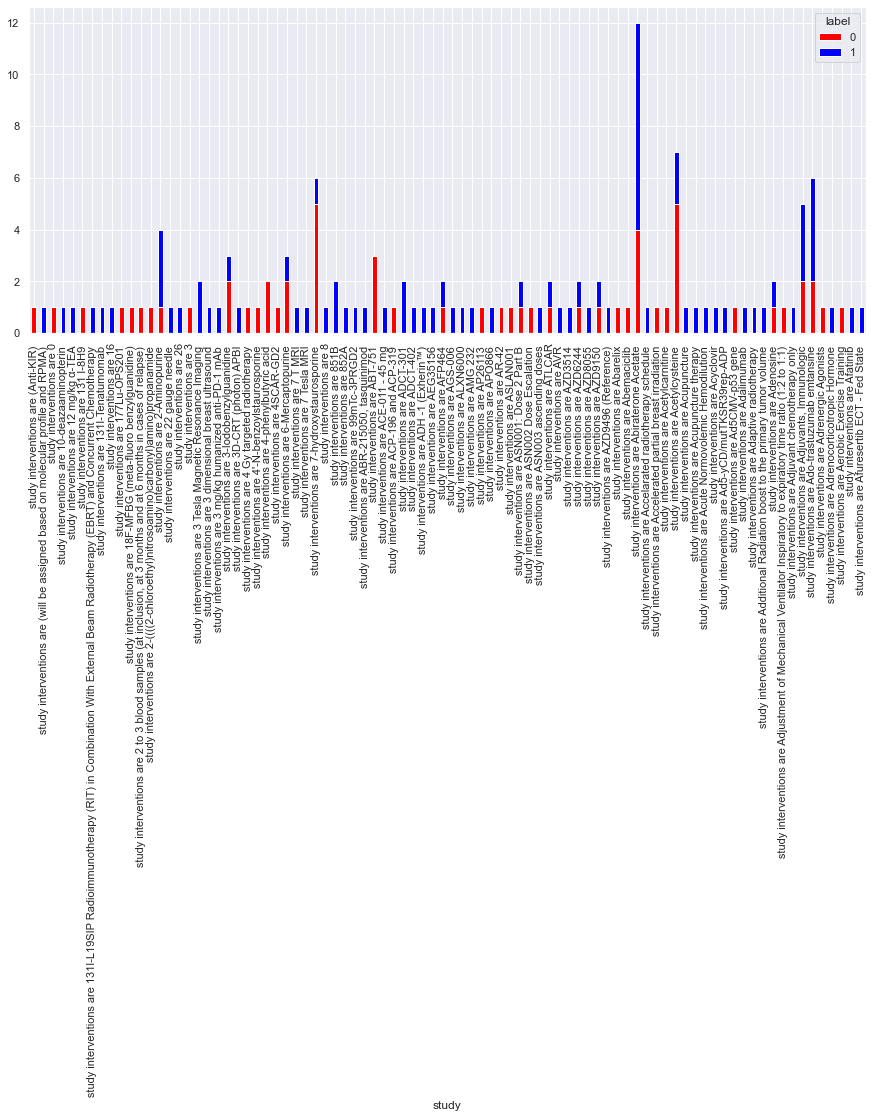

In [43]:
var1 = df_tracks.groupby(['study']).label.value_counts().head(100)

var1.unstack().plot(kind='bar',stacked=True,  color=['red','blue'], figsize=(15,6))

### 4.5. Identificacion de Palabras Clave

Ahora bien, si queremos entender e identificar algunas palabras clave importantes, se puede separar el texto que se tiene en la columna <code>cancer_type</code> en un arreglo, y de aqui hacer un conteo de las palabras y seleccionar las palabras posiblemente mas importantes o relevantes para el caso actual.

In [44]:
df_tracks['words'] = df_tracks.cancer_type.str.split(' ')
df_tracks.head()

label                                              study  \
0     0               study interventions are Saracatinib    
1     1  study interventions are Stem cell transplantat...   
2     0               study interventions are Lenograstim    
3     0               study interventions are Doxorubicin    
4     1                  study interventions are Poly I-C    

                                         cancer_type  \
0   recurrent verrucous carcinoma of the larynx d...   
1   hodgkin lymphoma diagnosis and history of con...   
2   recurrent adult diffuse mixed cell lymphoma d...   
3   stage iii diffuse large cell lymphoma diagnos...   
4   prostate cancer diagnosis and unresolved irae...   

                                               words  
0  [, recurrent, verrucous, carcinoma, of, the, l...  
1  [, hodgkin, lymphoma, diagnosis, and, history,...  
2  [, recurrent, adult, diffuse, mixed, cell, lym...  
3  [, stage, iii, diffuse, large, cell, lymphoma,...  
4  [, prostate, cancer, diagnosis, and, unresolve...

In [45]:
def count_words(df_tracks,col):
    rows = list()
    for row in df_tracks[['study', col]].iterrows():
        r = row[1]
        for word in r[col]:
            rows.append((r.study, word))

    words = pd.DataFrame(rows, columns=['study', 'word'])
    return words
words = count_words(df_tracks,'words')
words['word'] = words.word.str.lower()
words['word'].value_counts().head(50)

and             14274
                11988
diagnosis       11273
or               6185
of               6166
the              4549
cancer           4088
to               3306
lymphoma         2783
cell             2679
stage            2408
with             2398
patients         2181
for              1795
prior            1790
recurrent        1499
one              1423
carcinoma        1411
greater_than     1406
in               1351
study            1315
disease          1282
be               1270
have             1233
not              1200
therapy          1161
must             1152
breast           1142
less_than        1110
within           1089
are              1083
two               993
adult             931
no                912
at                880
any               875
is                871
non               848
other             840
treatment         834
doc               824
equal_than        805
three             791
hundred           733
who               733
history   

Como podemos ver, la mayoria de las palabras arriba no son de utilidad, puesto que palabras como 'and', 'or' o 'the', son palabras que se pueden repetir en todos los casos, y que por lo tanto no nos brindan informacion especial para el caso actual.

A continuacion, se hace un primer filtro de estas palabras no utiles haciendo uso de una libreria llamada <code>nltk</code>, que tiene unas _stopwords_, que son precisamente las palabras que buscamos eliminar. Por lo tanto, se crea una nueva columna llamada <code>filtered_words</code> sin este tipo de palabras.

In [46]:
def remove_stopwords(df_tracks, words):
    """Remove stop words from list of tokenized words"""
    rows = list()
    stop_words = set(stopwords.words('english'))
    filtered_words = []
    for row in df_tracks[['study', words]].iterrows():
        filtered_sentence = []
        r = row[1]
        for w in r[words]:
            if w not in stop_words:
                filtered_sentence.append(w) 
        filtered_words.append(filtered_sentence)
    return filtered_words

df_tracks['filtered_words']=remove_stopwords(df_tracks,'words')
df_tracks.head()

label                                              study  \
0     0               study interventions are Saracatinib    
1     1  study interventions are Stem cell transplantat...   
2     0               study interventions are Lenograstim    
3     0               study interventions are Doxorubicin    
4     1                  study interventions are Poly I-C    

                                         cancer_type  \
0   recurrent verrucous carcinoma of the larynx d...   
1   hodgkin lymphoma diagnosis and history of con...   
2   recurrent adult diffuse mixed cell lymphoma d...   
3   stage iii diffuse large cell lymphoma diagnos...   
4   prostate cancer diagnosis and unresolved irae...   

                                               words  \
0  [, recurrent, verrucous, carcinoma, of, the, l...   
1  [, hodgkin, lymphoma, diagnosis, and, history,...   
2  [, recurrent, adult, diffuse, mixed, cell, lym...   
3  [, stage, iii, diffuse, large, cell, lymphoma,...   
4  [, prostate, cancer, diagnosis, and, unresolve...   

                                      filtered_words  
0  [, recurrent, verrucous, carcinoma, larynx, di...  
1  [, hodgkin, lymphoma, diagnosis, history, cong...  
2  [, recurrent, adult, diffuse, mixed, cell, lym...  
3  [, stage, iii, diffuse, large, cell, lymphoma,...  
4  [, prostate, cancer, diagnosis, unresolved, ir...

A continuacion se vuelve a hacer un conteo de las palabras que no fueron eliminadas.

In [47]:
words = count_words(df_tracks,'filtered_words')
words['word'] = words.word.str.lower()
words['word'].value_counts().head(50)

                11988
diagnosis       11273
cancer           4088
lymphoma         2783
cell             2679
stage            2408
patients         2181
prior            1790
recurrent        1499
one              1423
carcinoma        1411
greater_than     1406
study            1315
disease          1282
therapy          1161
must             1152
breast           1142
less_than        1110
within           1089
two               993
adult             931
non               848
treatment         834
doc               824
equal_than        805
three             791
hundred           733
history           721
small             711
grade             686
iv                686
lung              667
weeks             662
days              655
patient           613
chemotherapy      585
tumor             571
metastatic        552
months            550
iii               541
myeloma           536
four              518
active            512
childhood         490
six               480
multiple  

### 4.6. Analisis desde los tipos de Cancer

Ahora bien, un análisis adicional que se le puede hacer a los datos es por ejemplo si se le hace una división por el tipo de cancer que el paciente tiene. Por ejemplo, tomemos dos casos: cuando el paciente tiene cancer en la linfa o de seno.

In [48]:
df_tracks=df_tracks.drop(['words'], axis=1)
df_tracks=df_tracks.drop(['filtered_words'], axis=1)
df_tracks.head(2)

label                                              study  \
0     0               study interventions are Saracatinib    
1     1  study interventions are Stem cell transplantat...   

                                         cancer_type  
0   recurrent verrucous carcinoma of the larynx d...  
1   hodgkin lymphoma diagnosis and history of con...

In [49]:
clintrial_lymphoma=df_tracks.loc[df_tracks.cancer_type.str.contains('\w*lymphoma')]
clintrial_breast=df_tracks.loc[df_tracks.cancer_type.str.contains('.*reast')]
print('clintrial_lymphoma',clintrial_lymphoma.shape)
print('clintrial_breast',clintrial_breast.shape)

clintrial_lymphoma (2825, 3)
clintrial_breast (1174, 3)


In [50]:
clintrial_lymphoma['words'] = clintrial_lymphoma.cancer_type.str.split(' ')
clintrial_breast['words'] = clintrial_breast.cancer_type.str.split(' ')

Palabras para <code>clintrial_lymphoma</code>

In [51]:
words_clintrial_lymphoma = count_words(clintrial_lymphoma,'words')
words_clintrial_lymphoma['word'] = words_clintrial_lymphoma.word.str.lower()
words_clintrial_lymphoma['word'].value_counts().head(25)

and             3423
                2823
diagnosis       2793
lymphoma        2783
of              1338
or              1286
cell            1228
the              952
stage            770
to               738
recurrent        705
adult            624
with             604
patients         529
for              477
large            417
one              396
grade            385
hodgkin          377
in               368
be               358
diffuse          353
greater_than     346
prior            343
less_than        331
Name: word, dtype: int64

Palabras para <code>clintrial_breast</code>

In [52]:
words_clintrial_breast = count_words(clintrial_breast,'words')
words_clintrial_breast['word'] = words_clintrial_breast.word.str.lower()
words_clintrial_breast['word'].value_counts().head(25)

and             1370
                1174
breast          1142
diagnosis       1104
cancer           934
or               709
of               575
the              423
to               318
stage            266
with             219
patients         191
prior            176
are              166
for              165
study            162
not              155
be               153
pregnant         148
disease          143
in               142
must             138
greater_than     129
one              128
have             126
Name: word, dtype: int64

Ahora bien, podemos ver entonces la influencia de diferentes palabras que podrian ser claves para el analisis los dos diferentes tipos, por ejemplo palabras como: _recurrent, stage ii, stage iii, stage iv, follicular, diffuse o hodgkin_.

A continuacion se muestran algunos resultados y analisis del tipo de cancer de lymphoma:

In [53]:
clintrial_lymphoma['recurrent'] = pd.np.where(clintrial_lymphoma.cancer_type.str.contains("\w*recurrent"), "recurrent","no")
clintrial_lymphoma['stage_ii'] = pd.np.where(clintrial_lymphoma.cancer_type.str.contains("\w*stage ii"), "stage_ii","no")
clintrial_lymphoma['stage_iii'] = pd.np.where(clintrial_lymphoma.cancer_type.str.contains("\w*stage iii"), "stage_iii","no")
clintrial_lymphoma['stage_iv'] = pd.np.where(clintrial_lymphoma.cancer_type.str.contains("\w*stage iv"), "stage_iv","no")
clintrial_lymphoma['follicular'] = pd.np.where(clintrial_lymphoma.cancer_type.str.contains("\w*follicular"), "follicular","no")
clintrial_lymphoma['diffuse'] = pd.np.where(clintrial_lymphoma.cancer_type.str.contains("\w*diffuse"), "diffuse","no")
clintrial_lymphoma['hodgkin'] = pd.np.where(clintrial_lymphoma.cancer_type.str.contains("\w*hodgkin"), "hodgkin","no")

clintrial_lymphoma.sample(25)

label                                              study  \
7572      0              study interventions are Prednisolone    
6860      0         study interventions are Mycophenolic Acid    
10810     0              study interventions are Asparaginase    
10714     1                 study interventions are Rituximab    
7543      1               study interventions are Maleic acid    
2318      1     study interventions are Fludarabine phosphate    
2247      1                study interventions are Tacrolimus    
2154      1                   study interventions are BB 1101    
5372      0                study interventions are Bortezomib    
4645      0    study interventions are Antibodies, Monoclonal    
9485      0                study interventions are Carmustine    
10815     1                 study interventions are Rituximab    
2025      0          study interventions are Cyclophosphamide    
7612      0              study interventions are Lenalidomide    
2999      1           study interventions are Immunoglobulins    
9320      1                study interventions are Dalteparin    
11039     1              study interventions are Cyclosporins    
11630     0                study interventions are Prednisone    
9713      0     study interventions are Mycophenolate mofetil    
9538      1                 study interventions are Rituximab    
1542      1  study interventions are Laboratory Biomarker A...   
4192      0      study interventions are Akt Inhibitor MK2206    
2129      1               study interventions are Maleic acid    
2725      0                 study interventions are Rituximab    
5673      1                 study interventions are Cortisone    

                                             cancer_type  \
7572    lymphoma diagnosis and initial disease bulk l...   
6860    childhood nasal type extranodal nk cell lymph...   
10810           lymphoma diagnosis and endocrine therapy   
10714   intraocular lymphoma diagnosis and intraventr...   
7543    recurrent adult burkitt lymphoma diagnosis an...   
2318    childhood grade iii lymphomatoid granulomatos...   
2247    recurrent adult hodgkin lymphoma diagnosis an...   
2154    stage iii adult lymphoblastic lymphoma diagno...   
5372    stage iv adult hodgkin lymphoma diagnosis and...   
4645    international prognostic index ipi or follicu...   
9485             lymphoma diagnosis and biologic therapy   
10815   stage grade one follicular lymphoma diagnosis...   
2025    other aggressive non dlbcl non burkitt non ho...   
7612    stage iv adult lymphoblastic lymphoma diagnos...   
2999    recurrent grade two follicular lymphoma diagn...   
9320    lymphoma diagnosis and concurrent high dose c...   
11039   recurrent childhood anaplastic large cell lym...   
11630   lymphoma diagnosis and at least thirty days s...   
9713    contiguous stage ii small lymphocytic lymphom...   
9538    contiguous stage ii small lymphocytic lymphom...   
1542    splenic marginal zone lymphoma diagnosis and ...   
4192    secondary central nervous system non hodgkin ...   
2129    stage iv adult diffuse small cleaved cell lym...   
2725    lymphoma diagnosis and transaminases less tha...   
5673    stage iib hodgkin lymphoma diagnosis and sexu...   

                                                   words  recurrent  stage_ii  \
7572   [, lymphoma, diagnosis, and, initial, disease,...         no        no   
6860   [, childhood, nasal, type, extranodal, nk, cel...         no        no   
10810   [, lymphoma, diagnosis, and, endocrine, therapy]         no        no   
10714  [, intraocular, lymphoma, diagnosis, and, intr...         no        no   
7543   [, recurrent, adult, burkitt, lymphoma, diagno...  recurrent        no   
2318   [, childhood, grade, iii, lymphomatoid, granul...         no        no   
2247   [, recurrent, adult, hodgkin, lymphoma, diagno...  recurrent        no   
2154   [, stage, iii, adult, lymphoblastic, lymphoma,...         no  stage_ii   

<AxesSubplot:xlabel='study,label'>

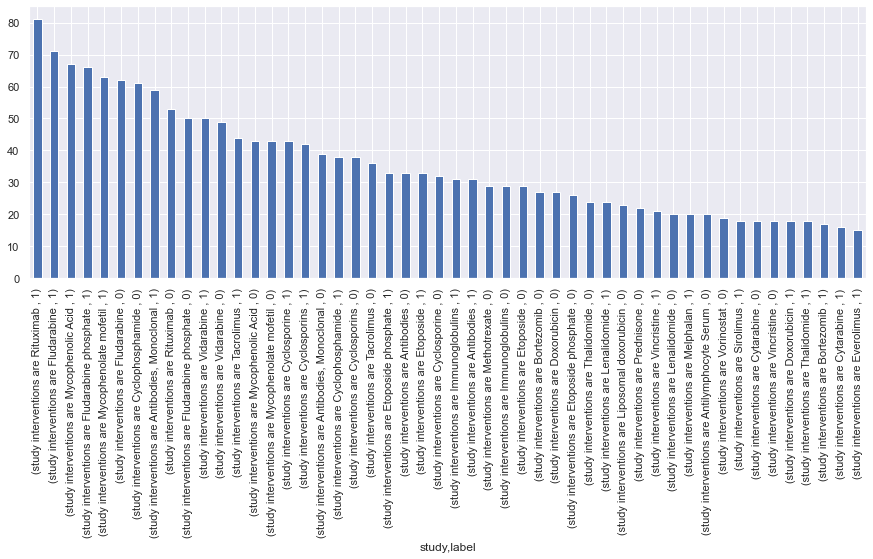

In [54]:
clintrial_lymphoma_select=clintrial_lymphoma.drop([ 'words'], axis=1)
var = clintrial_lymphoma_select.groupby(['study']).label.value_counts()
var_q = clintrial_lymphoma_select.groupby('study')['label'].value_counts().sort_values(ascending=False).head(50).plot(kind='bar', figsize=(15,5))
var_q

<AxesSubplot:xlabel='study,recurrent'>

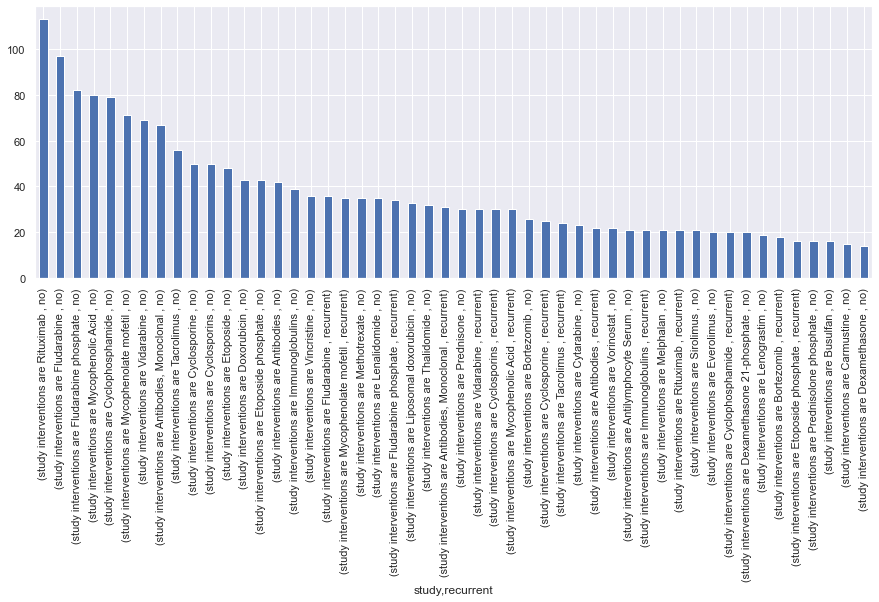

In [55]:
var_r = clintrial_lymphoma_select.groupby('study')['recurrent'].value_counts().sort_values(ascending=False).head(50).plot(kind='bar', figsize=(15,5))
var_r

<AxesSubplot:xlabel='study'>

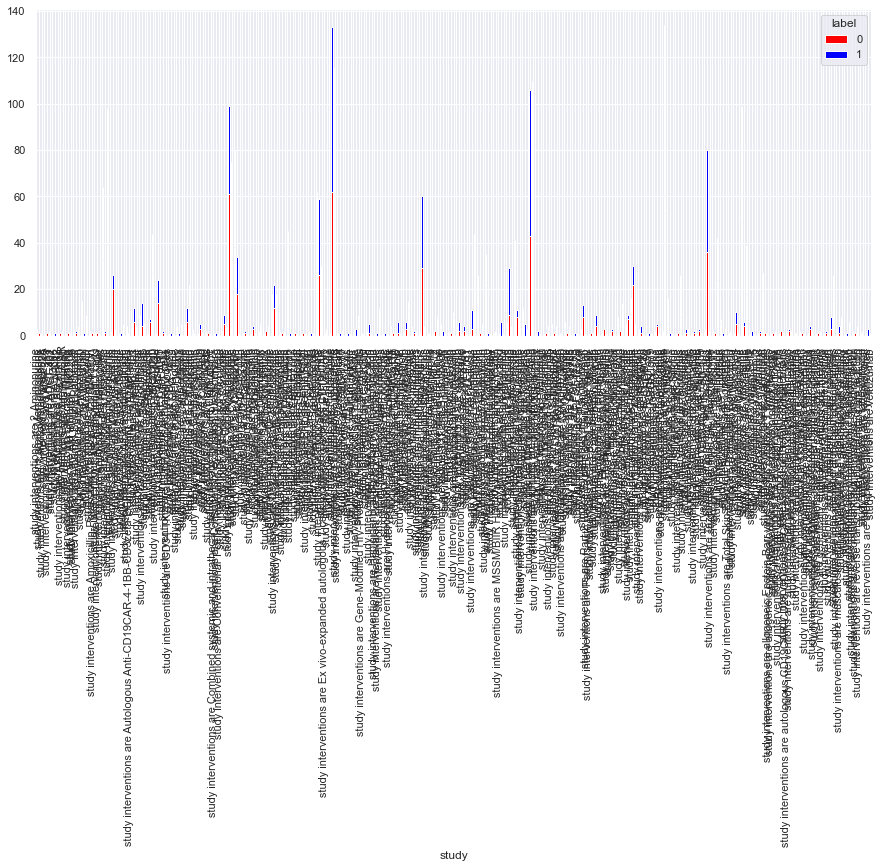

In [56]:
var1 = clintrial_lymphoma_select.groupby(['study']).label.value_counts()

var1.unstack().plot(kind='bar',stacked=True,  color=['red','blue'], figsize=(15,6))

A continuacion se muestran algunos resultados y analisis del tipo de cancer de seno:

In [57]:
clintrial_breast['recurrent'] = pd.np.where(clintrial_breast.cancer_type.str.contains("\w*recurrent"), "recurrent","no")
clintrial_breast['stage_ii'] = pd.np.where(clintrial_breast.cancer_type.str.contains("\w*stage ii"), "stage_ii","no")
clintrial_breast['stage_iii'] = pd.np.where(clintrial_breast.cancer_type.str.contains("\w*stage iii"), "stage_iii","no")
clintrial_breast['stage_iv'] = pd.np.where(clintrial_breast.cancer_type.str.contains("\w*stage iv"), "stage_iv","no")
clintrial_breast['follicular'] = pd.np.where(clintrial_breast.cancer_type.str.contains("\w*follicular"), "follicular","no")
clintrial_breast['diffuse'] = pd.np.where(clintrial_breast.cancer_type.str.contains("\w*diffuse"), "diffuse","no")
clintrial_breast['hodgkin'] = pd.np.where(clintrial_breast.cancer_type.str.contains("\w*hodgkin"), "hodgkin","no")

clintrial_lymphoma.sample(25)

label                                            study  \
11849     1             study interventions are Fludarabine    
5395      0             study interventions are Lenograstim    
2923      0             study interventions are Thalidomide    
11342     1   study interventions are Liposomal doxorubicin    
1138      1               study interventions are Rituximab    
6347      0              study interventions are Vidarabine    
9697      1   study interventions are Fludarabine phosphate    
5309      0  study interventions are Antibodies, Monoclonal    
1750      1  study interventions are Antibodies, Monoclonal    
6581      1  study interventions are Antibodies, Monoclonal    
11106     1               study interventions are Rituximab    
948       1              study interventions are Prednisone    
7884      0     study interventions are Etoposide phosphate    
2655      1            study interventions are Cyclosporine    
6195      1             study interventions are Fludarabine    
9953      1     study interventions are Etoposide phosphate    
11854     1        study interventions are Cyclophosphamide    
5352      1               study interventions are Rituximab    
4254      1   study interventions are Fludarabine phosphate    
2603      0         study interventions are Immunoglobulins    
4954      0             study interventions are Vincristine    
120       1  study interventions are Prednisolone phosphate    
9068      1               study interventions are Sirolimus    
1383      1                     study interventions are DLI    
9449      1               study interventions are Rituximab    

                                             cancer_type  \
11849   recurrent adult diffuse small cleaved cell ly...   
5395    stage iv adult diffuse large cell lymphoma di...   
2923    recurrent adult lymphoblastic lymphoma diagno...   
11342   stage iii adult lymphoblastic lymphoma diagno...   
1138    aids related plasmablastic lymphoma diagnosis...   
6347    recurrent childhood lymphoblastic lymphoma di...   
9697    recurrent refractory childhood hodgkin lympho...   
5309    stage marginal zone lymphoma diagnosis and mu...   
1750    refractory cell non hodgkin lymphoma diagnosi...   
6581    stage iv diffuse large cell lymphoma diagnosi...   
11106   contiguous stage ii marginal zone lymphoma di...   
948     lymphoma diagnosis and diagnosed or treated f...   
7884    recurrent adult grade iii lymphomatoid granul...   
2655    recurrent marginal zone lymphoma diagnosis an...   
6195    high grade non hodgkin lymphoma diagnosis and...   
9953    aids related peripheral systemic lymphoma dia...   
11854   nodal marginal zone cell lymphoma diagnosis a...   
5352    lymphoma large cell diffuse diagnosis and vir...   
4254    stage ii grade two contiguous follicular lymp...   
2603    recurrent small lymphocytic lymphoma diagnosi...   
4954    recurrent adult diffuse small cleaved cell ly...   
120     primary central nervous system cns lymphoma a...   
9068    recurrent adult hodgkin lymphoma diagnosis an...   
1383    lymphoma diagnosis and active infection defin...   
9449    stage iii cutaneous cell non hodgkin lymphoma...   

                                                   words  recurrent  stage_ii  \
11849  [, recurrent, adult, diffuse, small, cleaved, ...  recurrent        no   
5395   [, stage, iv, adult, diffuse, large, cell, lym...         no        no   
2923   [, recurrent, adult, lymphoblastic, lymphoma, ...  recurrent        no   
11342  [, stage, iii, adult, lymphoblastic, lymphoma,...         no  stage_ii   
1138   [, aids, related, plasmablastic, lymphoma, dia...         no        no   
6347   [, recurrent, childhood, lymphoblastic, lympho...  recurrent        no   
9697   [, recurrent, refractory, childhood, hodgkin, ...  recurrent        no   
5309   [, stage, marginal, zone, lymphoma, diagnosis,...         no        no   
1750   [, refractory, cell, non, hodgkin, lymphoma,

<AxesSubplot:xlabel='study,label'>

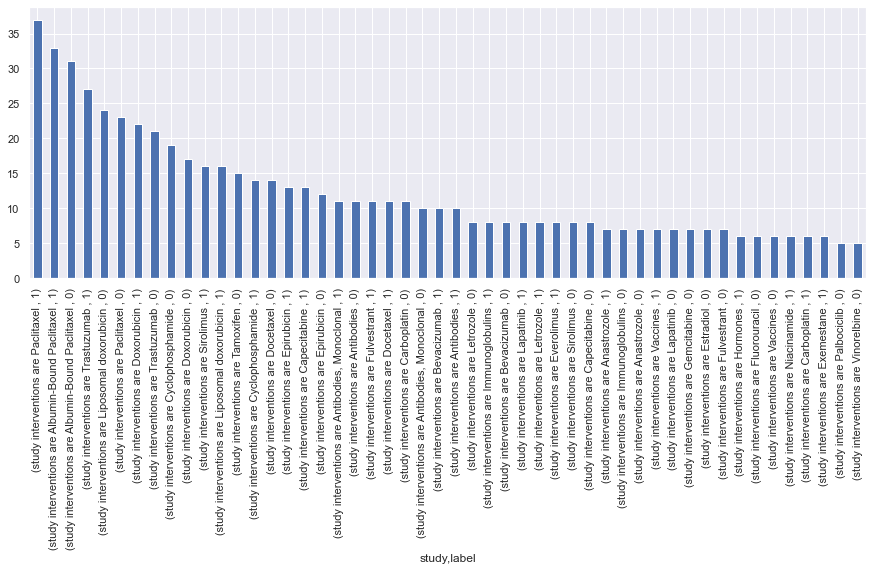

In [58]:
clintrial_breast_select=clintrial_breast.drop([ 'words'], axis=1)
var = clintrial_breast_select.groupby(['study']).label.value_counts()
var_q = clintrial_breast_select.groupby('study')['label'].value_counts().sort_values(ascending=False).head(50).plot(kind='bar', figsize=(15,5))
var_q

<AxesSubplot:xlabel='study,recurrent'>

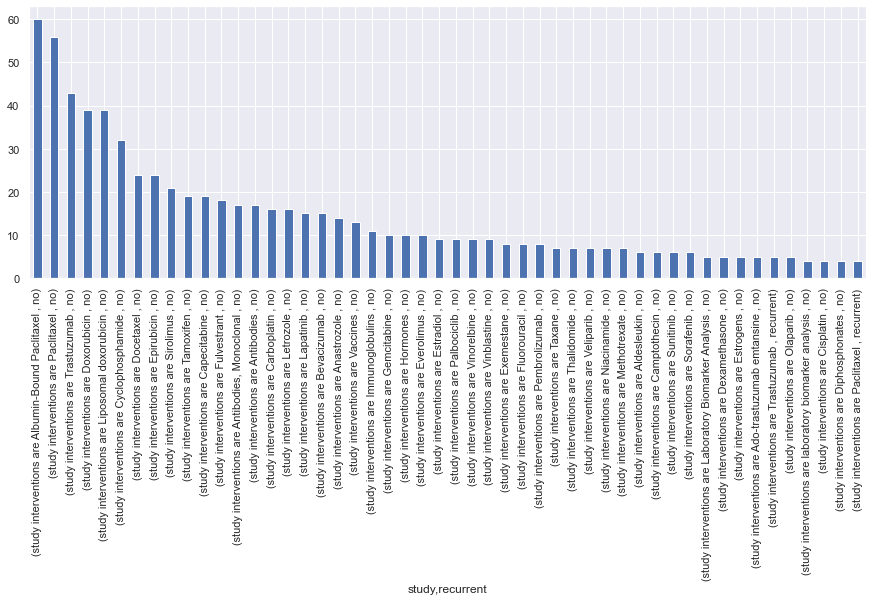

In [59]:
var_r = clintrial_breast_select.groupby('study')['recurrent'].value_counts().sort_values(ascending=False).head(50).plot(kind='bar', figsize=(15,5))
var_r

<AxesSubplot:xlabel='study'>

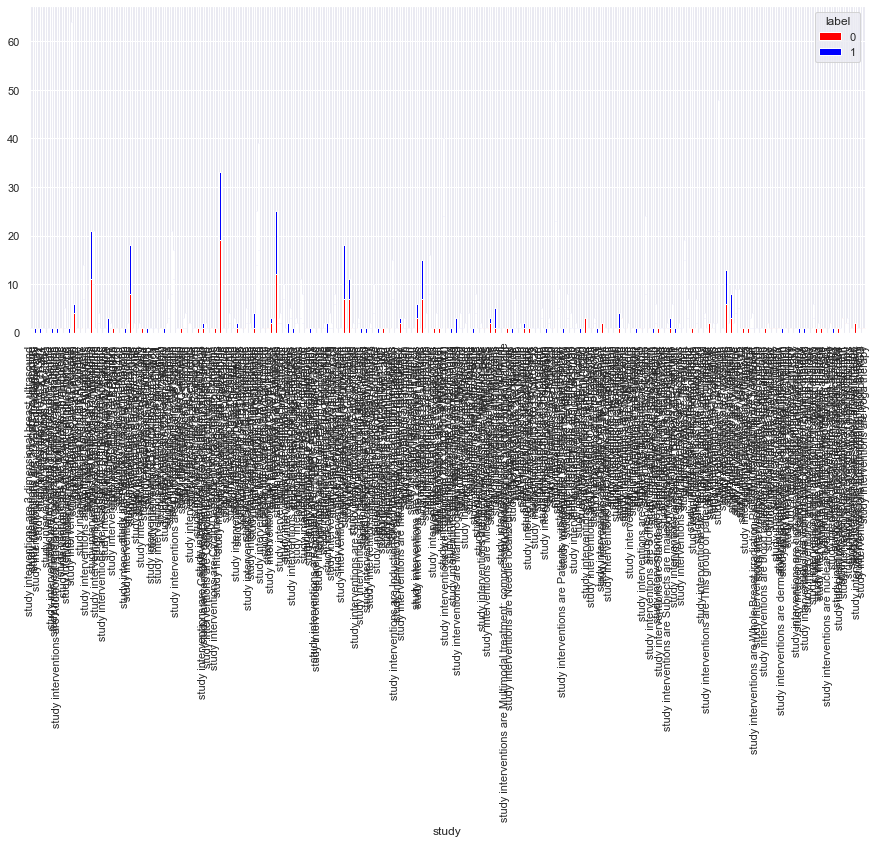

In [60]:
var1 = clintrial_breast_select.groupby(['study']).label.value_counts()

var1.unstack().plot(kind='bar',stacked=True,  color=['red','blue'], figsize=(15,6))

## 5. Preprocesamiento de los datos y toma de decisiones de acuerdo al negocio

A continuacion se hace un tratamiento de los datos (preparación o transformaciones requeridas), sobre la base del conocimiento del dominio y de los algoritmos seleccionados para resolver las tareas. 

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:

- Limpieza de los datos.
- Tokenización.
- Normalización.

### 5.1. Limpieza de los datos.

Anteriormente en la parte de analisis ya se hizo una parte de limpieza, sin embargo, se usaran los siguientes metodos, por si algun valor especifico o algo se paso de la limpieza anterior.

In [61]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    return words

### 5.2 Tokenización
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos, y luego se aplican los metodos de limpieza desarrollados anteriormente.

In [62]:
df_tracks['study'] = df_tracks['study'].apply(contractions.fix) #Aplica la corrección de las contracciones
df_tracks['cancer_type'] = df_tracks['cancer_type'].apply(contractions.fix) #Aplica la corrección de las contracciones
df_tracks.head()

label                                              study  \
0     0               study interventions are Saracatinib    
1     1  study interventions are Stem cell transplantat...   
2     0               study interventions are Lenograstim    
3     0               study interventions are Doxorubicin    
4     1                  study interventions are Poly I-C    

                                         cancer_type  
0   recurrent verrucous carcinoma of the larynx d...  
1   hodgkin lymphoma diagnosis and history of con...  
2   recurrent adult diffuse mixed cell lymphoma d...  
3   stage iii diffuse large cell lymphoma diagnos...  
4   prostate cancer diagnosis and unresolved irae...

In [63]:
df_tracks['words_study'] = df_tracks['study'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
df_tracks['words_cancer_type'] = df_tracks['cancer_type'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
df_tracks['filtered_words_cancer_type']=remove_stopwords(df_tracks,'words_cancer_type')
df_tracks['filtered_words_study']=remove_stopwords(df_tracks,'words_study')

df_tracks.head()

label                                              study  \
0     0               study interventions are Saracatinib    
1     1  study interventions are Stem cell transplantat...   
2     0               study interventions are Lenograstim    
3     0               study interventions are Doxorubicin    
4     1                  study interventions are Poly I-C    

                                         cancer_type  \
0   recurrent verrucous carcinoma of the larynx d...   
1   hodgkin lymphoma diagnosis and history of con...   
2   recurrent adult diffuse mixed cell lymphoma d...   
3   stage iii diffuse large cell lymphoma diagnos...   
4   prostate cancer diagnosis and unresolved irae...   

                                         words_study  \
0           [study, interventions, are, Saracatinib]   
1  [study, interventions, are, Stem, cell, transp...   
2           [study, interventions, are, Lenograstim]   
3           [study, interventions, are, Doxorubicin]   
4              [study, interventions, are, Poly, IC]   

                                   words_cancer_type  \
0  [recurrent, verrucous, carcinoma, of, the, lar...   
1  [hodgkin, lymphoma, diagnosis, and, history, o...   
2  [recurrent, adult, diffuse, mixed, cell, lymph...   
3  [stage, iii, diffuse, large, cell, lymphoma, d...   
4  [prostate, cancer, diagnosis, and, unresolved,...   

                          filtered_words_cancer_type  \
0  [recurrent, verrucous, carcinoma, larynx, diag...   
1  [hodgkin, lymphoma, diagnosis, history, congen...   
2  [recurrent, adult, diffuse, mixed, cell, lymph...   
3  [stage, iii, diffuse, large, cell, lymphoma, d...   
4  [prostate, cancer, diagnosis, unresolved, irae...   

                                filtered_words_study  
0                [study, interventions, Saracatinib]  
1  [study, interventions, Stem, cell, transplanta...  
2                [study, interventions, Lenograstim]  
3                [study, interventions, Doxorubicin]  
4                   [study, interventions, Poly, IC]

### 5.3. Normalización

En la normalización de los datos se realiza la eliminación de prefijos y sufijos, además de realizar una lemmatización.

In [64]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

df_tracks['filtered_words_cancer_type'] = df_tracks['filtered_words_cancer_type'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
df_tracks['filtered_words_study'] = df_tracks['filtered_words_study'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
df_tracks.head()

label                                              study  \
0     0               study interventions are Saracatinib    
1     1  study interventions are Stem cell transplantat...   
2     0               study interventions are Lenograstim    
3     0               study interventions are Doxorubicin    
4     1                  study interventions are Poly I-C    

                                         cancer_type  \
0   recurrent verrucous carcinoma of the larynx d...   
1   hodgkin lymphoma diagnosis and history of con...   
2   recurrent adult diffuse mixed cell lymphoma d...   
3   stage iii diffuse large cell lymphoma diagnos...   
4   prostate cancer diagnosis and unresolved irae...   

                                         words_study  \
0           [study, interventions, are, Saracatinib]   
1  [study, interventions, are, Stem, cell, transp...   
2           [study, interventions, are, Lenograstim]   
3           [study, interventions, are, Doxorubicin]   
4              [study, interventions, are, Poly, IC]   

                                   words_cancer_type  \
0  [recurrent, verrucous, carcinoma, of, the, lar...   
1  [hodgkin, lymphoma, diagnosis, and, history, o...   
2  [recurrent, adult, diffuse, mixed, cell, lymph...   
3  [stage, iii, diffuse, large, cell, lymphoma, d...   
4  [prostate, cancer, diagnosis, and, unresolved,...   

                          filtered_words_cancer_type  \
0  [recur, verruc, carcinom, larynx, diagnos, pat...   
1  [hodgkin, lymphom, diagnos, hist, congenit, he...   
2  [recur, adult, diffus, mix, cel, lymphom, diag...   
3  [stag, ii, diffus, larg, cel, lymphom, diagnos...   
4  [prost, cant, diagnos, unresolv, ira, follow, ...   

                                filtered_words_study  
0  [study, interv, saracatinib, study, interventi...  
1  [study, interv, stem, cel, transpl, study, int...  
2  [study, interv, lenograstim, study, interventi...  
3  [study, interv, doxorubicin, study, interventi...  
4  [study, interv, poly, ic, study, interventions...

In [65]:
data_t = df_tracks
data_t['filtered_words_cancer_type'] = data_t['filtered_words_cancer_type'].apply(lambda x: ' '.join(map(str, x)))
data_t['filtered_words_study'] = data_t['filtered_words_study'].apply(lambda x: ' '.join(map(str, x)))

data_t = data_t.drop(['study','cancer_type','words_study','words_cancer_type'], axis=1)
data_t.head()

label                         filtered_words_cancer_type  \
0     0  recur verruc carcinom larynx diagnos paty must...   
1     1  hodgkin lymphom diagnos hist congenit hematolo...   
2     0  recur adult diffus mix cel lymphom diagnos cre...   
3     0  stag ii diffus larg cel lymphom diagnos stag i...   
4     1  prost cant diagnos unresolv ira follow pri bio...   

                                filtered_words_study  
0  study interv saracatinib study interventions S...  
1  study interv stem cel transpl study interventi...  
2  study interv lenograstim study interventions L...  
3  study interv doxorubicin study interventions D...  
4   study interv poly ic study interventions Poly IC

In [66]:
data_t['label'] = data_t['label'].astype(int)

### 5.4. Division de los Datos

Ahora bien, se hara una division de los datos, dejando 3 opciones diferentes para los datos en $X$, esto se debe a que como hay una division entre la informacion sobre el estudio y la informacion sobre el tipo de cancer. Por lo tanto para separar los datos se dejaron 3 opciones de trabajo para utilizar en los modelos:
- Se tiene por separado los datos de solo la columna <code>filtered_words_cancer_type</code>
- Se tiene por separado los datos de solo la columna <code>filtered_words_study</code>
- Se tienen los datos de las dos columnas.

In [67]:
data_t["study_and_condition2"] = data_t["filtered_words_study"] + "." + data_t["filtered_words_cancer_type"]
y_data, X_data_cancer, X_data_study, X_data_junto = data_t['label'], data_t['filtered_words_cancer_type'], data_t['filtered_words_study'], data_t['study_and_condition2']

vectorizer1 = CountVectorizer(stop_words='english')
X_data_cancer = vectorizer1.fit_transform(X_data_cancer)
cancer_feature_names = vectorizer1.get_feature_names()

vectorizer2 = CountVectorizer(stop_words='english')
X_data_study = vectorizer2.fit_transform(X_data_study)
study_feature_names = vectorizer2.get_feature_names()

vectorizer3 = CountVectorizer(stop_words='english')
X_data_junto = vectorizer3.fit_transform(X_data_junto)
junto_feature_names = vectorizer3.get_feature_names()

print('X_data_cancer:',X_data_cancer.shape)
print('X_data_study:',X_data_study.shape)
print('X_data_junto:',X_data_junto.shape)
print('y_data:',y_data.shape)

X_data_cancer: (12000, 8966)
X_data_study: (12000, 3186)
X_data_junto: (12000, 10745)
y_data: (12000,)


In [68]:
print(len(cancer_feature_names))
print(len(study_feature_names))
print(len(junto_feature_names))

8966
3186
10745


## 6. Modelado y evaluación

A continuacion se hace la aplicación de tres algoritmos diferentes para la tarea de aprendizaje de máquina seleccionada. En esta parte se van describir los algoritmos utilizados, haciendo una justificacion del porque se uso cada uno de estos modelos, asi como se describira el algoritmo para la construcción de los modelos y se hara una presentación de los resultados de la evaluación cuantitativa. 

### 6.1. Arboles de Clasificacion

#### 6.1.1. Entendimiento del Algoritmo

Los arboles de decision, son uno de los algoritmos de aprendizaje supervisado más utilizados en machine learning y pueden realizar tareas de clasificación o regresión. En este sentido, los arboles de decisión son representaciones gráficas de posibles soluciones a una decisión basadas en ciertas condiciones. 

Para obtener el árbol óptimo y valorar cada subdivisión entre todos los árboles posibles y conseguir el nodo raiz y los subsiguientes, el algoritmo deberá medir de alguna manera las predicciones logradas y valorarlas para comparar de entre todas y obtener la mejor. Para medir y valorar, utiliza diversas funciones, siendo las más conocidas y usadas los _“Indice gini”_ y _“Ganancia de información”_ que utiliza la denominada _“entropía“_. La división de nodos continuará hasta que lleguemos a la profundidad máxima posible del árbol ó se limiten los nodos a una cantidad mínima de muestras en cada hoja

Teniendo en cuenta lo anterior, este algoritmo se escogió, pues es ayuda a definir las caracteristicas mas importantes al momento de hacer la predicción, en este sentido, se va a usar el arbol de clasificación para poder entender que palabras son posiblemente las más relevantes al momento de tomar una decisión si el paciente es elegible o no.

#### 6.1.2. Entrenamiento del modelo

Ahora bien, para lograr el objetivo anteriormente mencionado, se van a utilizar los datos de los datos en conjunto, y se intentara hacer un analisis de las palabras clave mas importantes, para la realizacion del modelo de prediccion.

In [69]:
df_bow_sklearn = pd.DataFrame(X_data_junto.toarray(),columns=junto_feature_names)
df_bow_sklearn['label']=y_data
df_bow_sklearn.head()

01  05  0pd  0three_two9  0two_two009  10deazaaminopterin  11  12  \
0   0   0    0            0            0                   0   0   0   
1   0   0    0            0            0                   0   0   0   
2   0   0    0            0            0                   0   0   0   
3   0   0    0            0            0                   0   0   0   
4   0   0    0            0            0                   0   0   0   

   12_teaspoon  131il19sip  ...  zoledron  zoledronate  zoledronic  zolmitrib  \
0            0           0  ...         0            0           0          0   
1            0           0  ...         0            0           0          0   
2            0           0  ...         0            0           0          0   
3            0           0  ...         0            0           0          0   
4            0           0  ...         0            0           0          0   

   zolmitriptan  zomet  zometa  zon  zone  zubrod  
0             0      0       0    0     0       0  
1             0      0       0    0     0       0  
2             0      0       0    0     0       0  
3             0      0       0    0     0       0  
4             0      0       0    0     0       0  

[5 rows x 10745 columns]

Primero, se hace la division de los datos entre datos de entrenamiento y datos de test.

In [35]:
x_train, x_test, y_train, y_test = train_test_split(df_bow_sklearn.drop(['label'],axis=1), df_bow_sklearn['label'], test_size=0.2, random_state=0)

Ahora bien, para lograr el objetivo anteriormente mencionado, haciendo uso de una validacion cruzada, que divide en k particiones disjuntas el conjunto de datos de entrenamiento. Luego, se fija un valor de hiperparámetro y se toma como conjunto de validación la primera partición y el resto para entrenar el modelo. Este proceso se repite para cada partición. Al finalizar, se determina el valor promedio de las métricas seleccionadas. Este ciclo se repite sobre diferentes valores del hiperparámetro y se seleccionan aquel que ofrezcan el mejor rendimiento.

Scikit-learn ofrece algunos métodos que automatizan el proceso de buscar los valores de los hiperparámetros. Uno de ellos es GridSearchCV, el cual se basa en la validación cruzada de k-particiones. Por lo tanto, a continuacion, se hace uso de este algoritmo, en funcion de encontrar los mejores hiperparametros para la construccion de nuestro arbol de deciion

In [36]:
# Definimos pipeline:
arbolito = DecisionTreeClassifier()
# particiones = KFold(n_splits=15, shuffle=True, random_state = 0)

# Definimos hiperparámetros:
gryd_hyper_arbolito = {'criterion':['gini', 'entropy'],'max_depth':[2,3,4,5,6],'min_samples_split':[2, 3, 4, 5, 6]} # {"max_depth": [ 3, 4, 5, 7, 8, 9]}  

gs_arbolito = GridSearchCV(arbolito, gryd_hyper_arbolito, cv=10)

# lanzamos el entrenamiento del modelo:
gs_arbolito.fit(x_train, y_train) 

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 6]})

In [37]:
# Vemos cual es la mejor profundidad:
gs_arbolito.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 5}

In [38]:
# Vemos el acierto de nuestro modelo:
gs_arbolito.best_score_

0.6166666666666667

In [39]:
arbol_final = gs_arbolito.best_estimator_
arbol_final

DecisionTreeClassifier(max_depth=6, min_samples_split=5)

In [40]:
# Probemos ahora este modelo sobre test.
y_pred_train = arbol_final.predict(x_train)
y_pred_test = arbol_final.predict(x_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.62
Exactitud sobre test: 0.61


#### 6.1.2. Conclusiones del Modelo

Como se pudo observar en la parte anterior, el mejor modelo encontrado haciendo uso de los arboles de decisión es:

<code>mejor_modelo={'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 5}</code>

Es decir, un modelo que haga uso del citerio de gini, tenga una profundidad maxima de 6 y el minimo numero de ejemplos sea 5. A continuacion, se hara un analisis haciendo uso de las matrices de confusion, de dibujar el arbol y de la clasificacion de las caracteristicas mas importantes sobre el modelo.

Matriz para datos de ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.57      0.93      0.71      4772
           1       0.83      0.31      0.45      4828

    accuracy                           0.62      9600
   macro avg       0.70      0.62      0.58      9600
weighted avg       0.70      0.62      0.58      9600

[[4457  315]
 [3327 1501]]


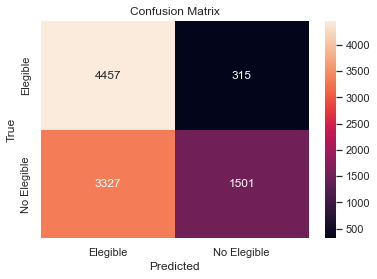

In [41]:
print("Matriz para datos de ENTRENAMIENTO")
print(classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Elegible', 'No Elegible']); ax.yaxis.set_ticklabels(['Elegible', 'No Elegible']);

Como se puede observar, la clasificacion es buena, pues tiene una exactitud de 0.62. En cuanto a la precision de la clasificacion de cada una de las clases se puede decir que el modelo lo hace correctamente para los datos de entrenamiento para la clase 1, pero no tan bien para la clase 0, pues la precision es de 0.59 y 0.88, respectivamente. Es decir que los datos que clasifica como verdaderos positivos respecto a el total de datos que clasifica como positivos es bastante bueno para los papcientes que no son elegibles, y no tanto para aquellos que no lo son. Adicionalmente la sensibilidad de aquellos datos que clasifica como verdaderos con respecto al total que son verdaderos, es buena para la clase 0 (pacientes elegidos), pero no para la clase 1 (pacientes no elegidos) pues el recall que mide esta sensibilidad es alto, aqui se puede ver que principalmente para la clase 1 hacer mejor el trabajo. De igual forma, la exactitud general del modelo (0.93) es buena.

Sin embargo, los datos que mas nos interesa ver como se maneja el modelo son los datos de prueba, pues queremos ver que el modelo funcione aun cuando no conoce los datos con anterioridad, esto se muestra a continuacion.

Matriz para datos de PRUEBA
              precision    recall  f1-score   support

           0       0.57      0.92      0.71      1228
           1       0.78      0.28      0.41      1172

    accuracy                           0.61      2400
   macro avg       0.67      0.60      0.56      2400
weighted avg       0.67      0.61      0.56      2400

[[1134   94]
 [ 846  326]]


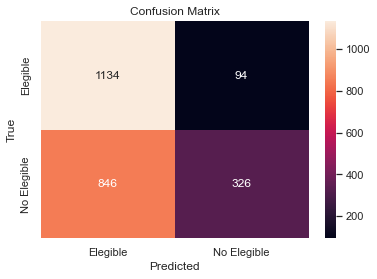

In [42]:
print("Matriz para datos de PRUEBA")
print(classification_report(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Elegible', 'No Elegible']); ax.yaxis.set_ticklabels(['Elegible', 'No Elegible']);

Como se puede observar, aqui la clasificacion tambien es buena, pues tiene una exactitud 0.61. En cuanto a la precision de la clasificacion de cada una de las clases se puede decir que el modelo lo hace correctamente para los datos de la clase 1, sin embargo no clasifica tan bien los datos de la clase 0. Esto quiere decir que, los datos que clasifica como verdaderos positivos respecto a el total de datos que clasifica como positivos es bastante bueno para la clase 1 (pacientes no elegidos). Adicionalmente la sensibilidad de aquellos datos que clasifica como verdaderos con respecto al total que son verdaderos, es muy buena tambien para la clase 0, pues tiene un recall de 0.92, pero para la clase 1 lo hace no muy bien (0.28). 

Ahora bien, observemos el arbol final que construye el modelo:

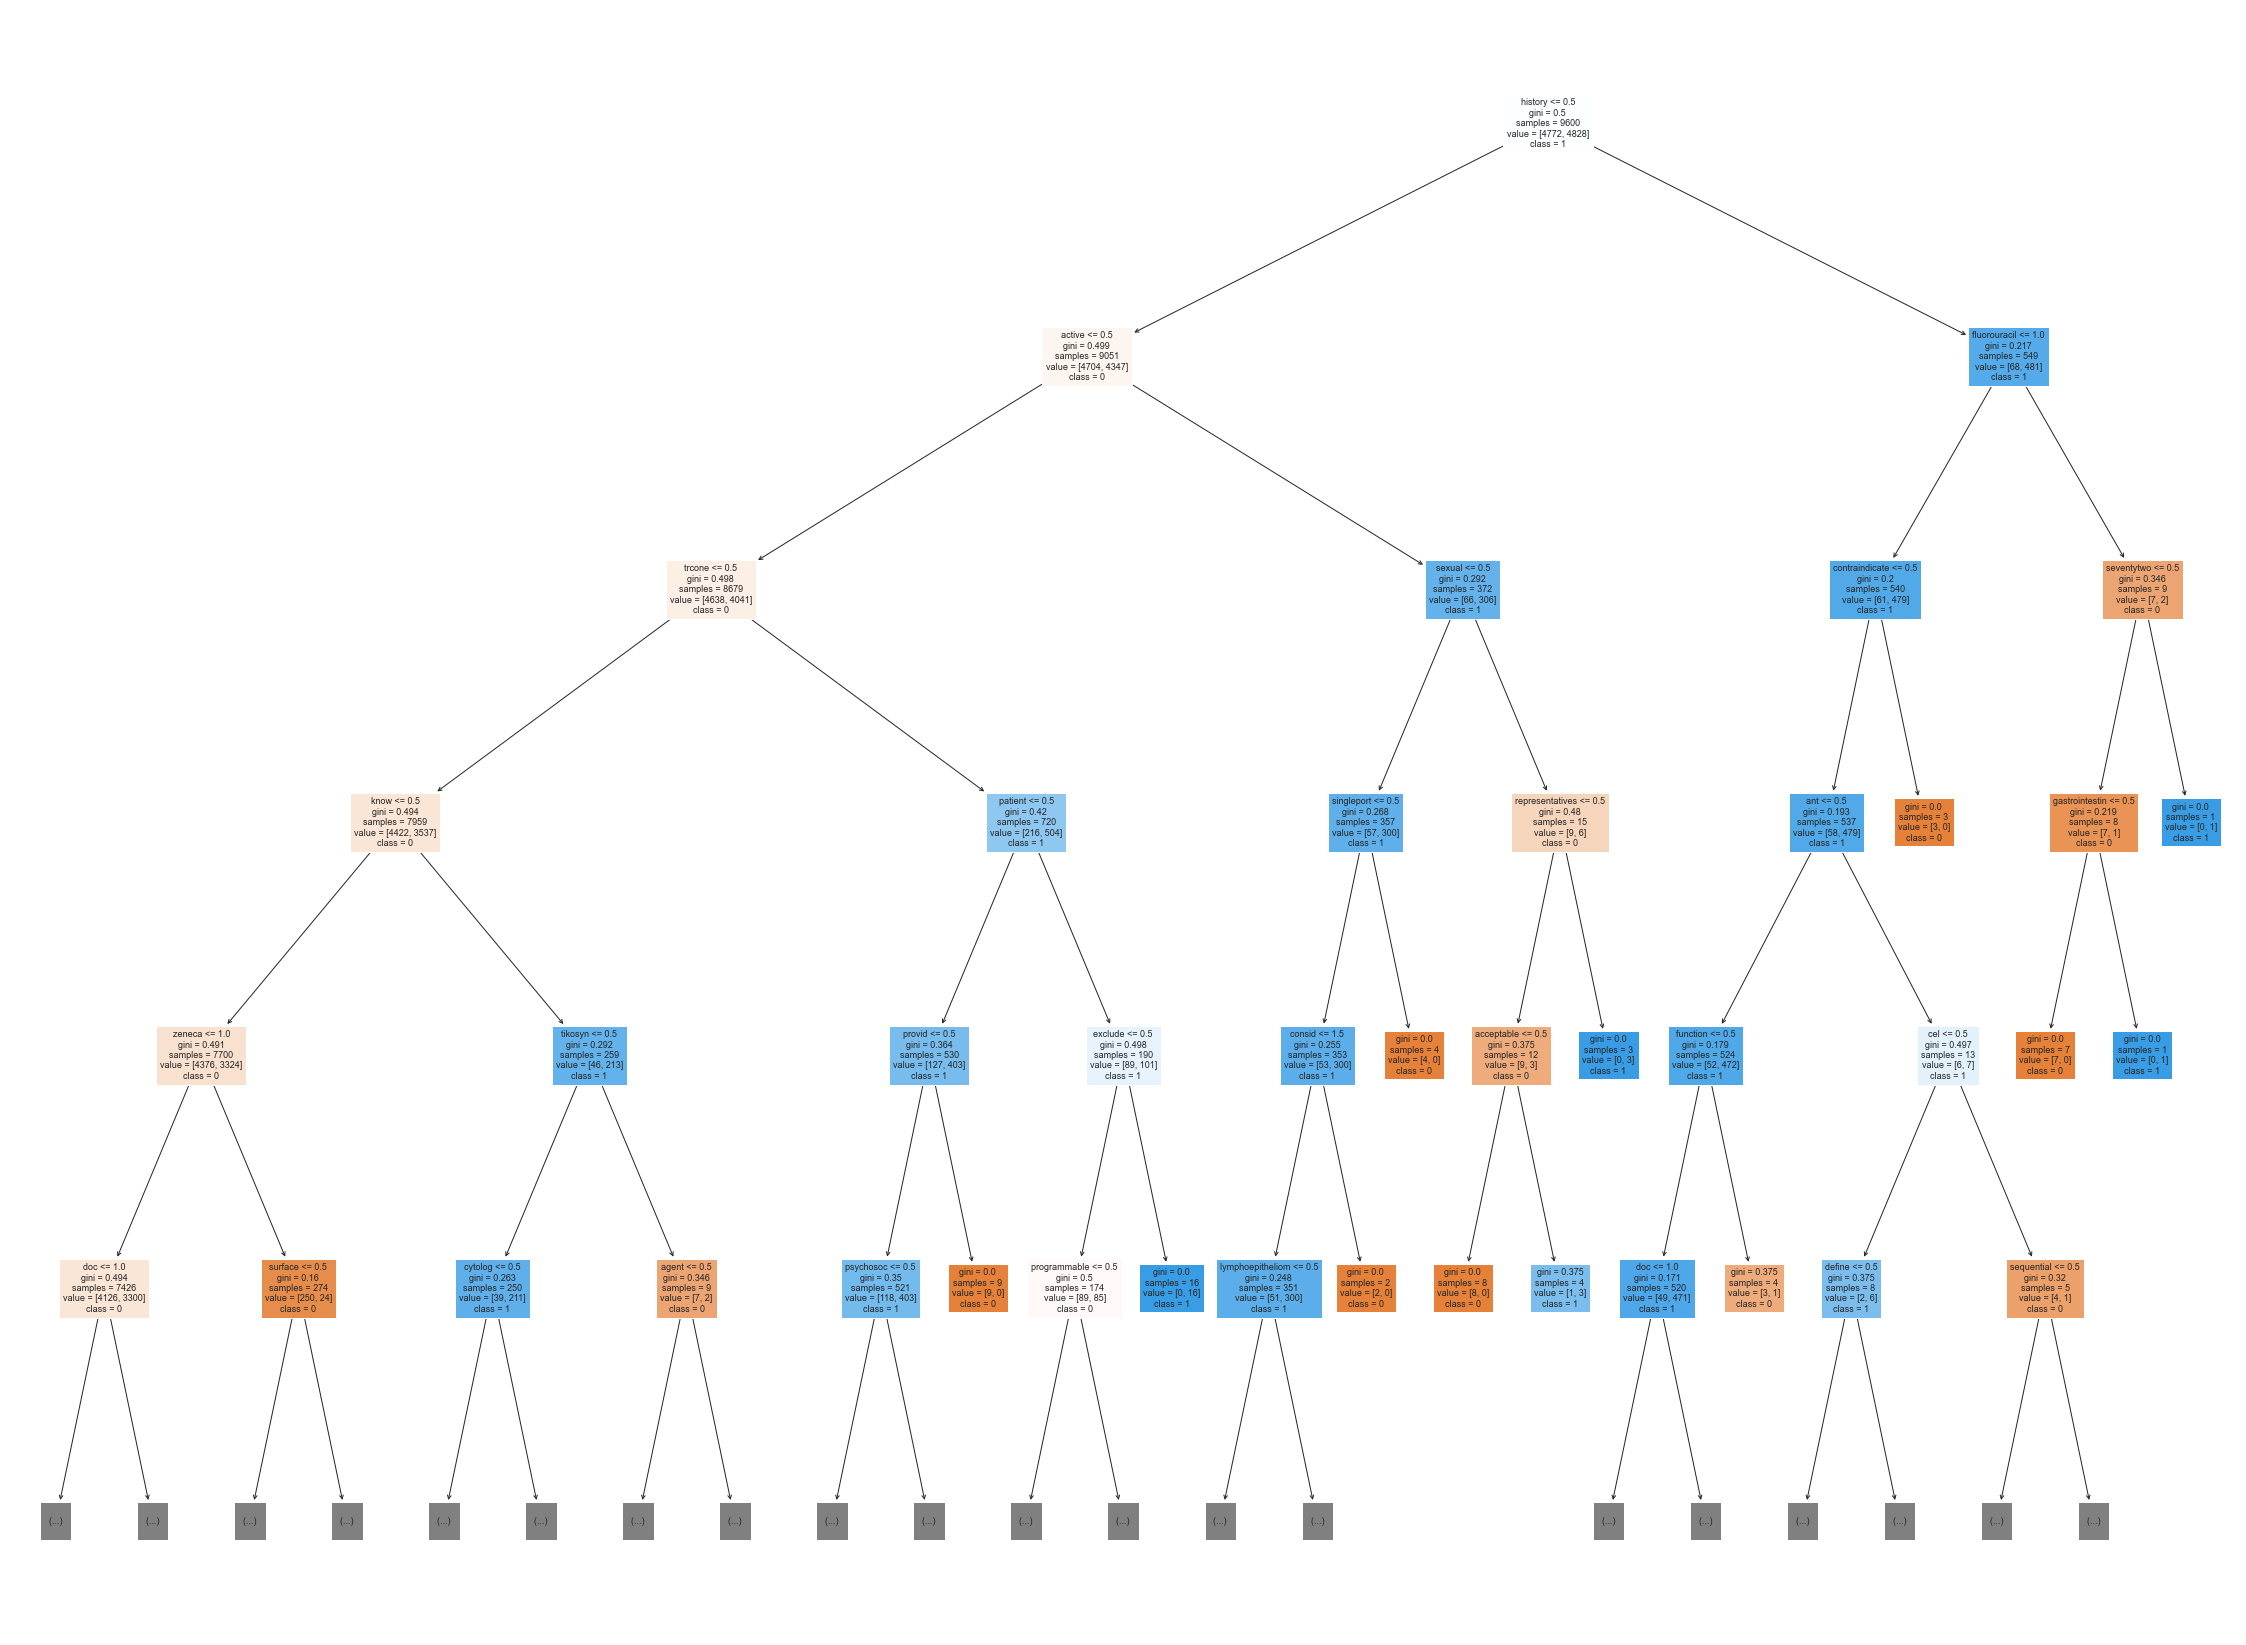

In [43]:
fig = plt.figure(figsize=(40,30))
_ = tree.plot_tree(arbol_final, max_depth=5, feature_names=df_bow_sklearn.columns, class_names=["0", "1"], filled=True, fontsize=9)

In [44]:
# También podemos guardar esta figura como una imagen.
fig.savefig("decistion_tree_final.png")

In [55]:
feature_importance = pd.DataFrame(arbol_final.feature_importances_, index=x_train.columns)
print(feature_importance.sort_values(by=0, ascending=False)[:30])
# feature_importance.plot(kind='hist')

                          0
history            0.244712
active             0.137140
tre                0.130139
know               0.115400
zero               0.101490
doc                0.096645
patients           0.022089
provide            0.015970
psychosocial       0.011869
fluorouracil       0.011804
exclude            0.011566
surg               0.010195
tim                0.010133
progress           0.008627
sint               0.008619
sexually           0.008421
contraindicate     0.007161
cytolog            0.006526
function           0.005150
ant                0.005024
acceptable         0.004525
lymphoepithelioma  0.004433
consid             0.004383
reproduc           0.004073
cel                0.002808
gastrointestin     0.002640
ser                0.002414
agent              0.002053
severe             0.002053
define             0.001939


Ahora bien, en cuanto a esto ultimo, se puede observar que no hay palabras fundamentalmente importantes, pues las que aparecen como palabras mas determinantes no son fundamentales para la caracterizacion del cancer.

### 6.2. K-Nearest Neighbors

#### 6.2.1 Entendiendo el Algortimo

El algoritmo de KNN es uno de clasificación supervisada, el cual se usa para para estimar la probabilidad que tiene un elemento de pertenecer a cierta clase según sus caracteristicas dadas. En el reconocimiento de patrones, este algortimo es usado como un método de clasificación basado en entrenamiento mediante ejemplos ceranos al espacio de elementos. 

En este sentido, las ventajas que tiene este algoritmo, y que por lo tanto, se pensó en utilizar son:
- El algoritmo es simple y fácil de implementar.
- No hay necesidad de construir un modelo, ajustar varios parámetros o hacer suposiciones adicionales.
- El algoritmo es versátil. Puede usarse para clasificación, regresión y búsqueda (como veremos en la siguiente sección).

En este caso, vamos a identificar si es posible encontrar un modelo preciso de predicción de clasificación que se construya a partir de encontrar los vecinos mas cercanos.

#### 6.2.2 Entrenamiento del modelo
Con el fin de determinar la probabilidad que tiene un nuevo paciente de ser elegible o no, se decidió trabajar sobre el conjunto de los datos en conjunto, con el fin de tener una estimación más acertada. 

In [34]:
from sklearn.neighbors import KNeighborsClassifier

#Se crea un nuevo conjunto de datos a partir de los datos en conjunto
df_bow_sklearn = pd.DataFrame(X_data_junto.toarray(),columns=junto_feature_names)
df_bow_sklearn['label']=y_data

01  05  0pd  0three_two9  0two_two009  10deazaaminopterin  11  12  \
0   0   0    0            0            0                   0   0   0   
1   0   0    0            0            0                   0   0   0   
2   0   0    0            0            0                   0   0   0   
3   0   0    0            0            0                   0   0   0   
4   0   0    0            0            0                   0   0   0   

   12_teaspoon  131il19sip  ...  zoledron  zoledronate  zoledronic  zolmitrib  \
0            0           0  ...         0            0           0          0   
1            0           0  ...         0            0           0          0   
2            0           0  ...         0            0           0          0   
3            0           0  ...         0            0           0          0   
4            0           0  ...         0            0           0          0   

   zolmitriptan  zomet  zometa  zon  zone  zubrod  
0             0      0       0    0     0       0  
1             0      0       0    0     0       0  
2             0      0       0    0     0       0  
3             0      0       0    0     0       0  
4             0      0       0    0     0       0  

[5 rows x 10745 columns]

Se hace la división de los datos en conjunto de entrenamiento y conjunto de prueba

In [35]:
X = df_bow_sklearn.drop(['label'], axis = 1)
Y = df_bow_sklearn['label']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

Una vez realizada la partición de los datos, se procede a hacer el cálculo de los hiperparametros del algortimo con el fin de tener el mejor modelo posible para el problema, para esto se define un espacio de busqueda para $k$ entre 1 y 11, y posteriormente, con ayuda de GridSearchCV, se define cual es el mejor modelo.

In [36]:
n_vecinos =  list(range(1,11))
param_grid = {'n_neighbors': n_vecinos, 'p': [1, 2]}
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

In [37]:
clasificadorKNN = KNeighborsClassifier()
modelo_Knn = GridSearchCV(clasificadorKNN, param_grid, cv=particiones)
modelo_Knn.fit(x_train,y_train) 
print("Mejor parámetro: {}".format(modelo_Knn.best_params_)) 
print("Mejor cross-validation score: {:.2f}".format(modelo_Knn.best_score_))

Mejor parámetro: {'n_neighbors': 1, 'p': 1}
Mejor cross-validation score: 0.70


In [67]:
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_test))

Exactitud sobre entrenamiento: 1.00
Exactitud sobre test: 0.70


Una vez hecha la busqueda, se encontro que el mejor modelo es:

<code>mejor_modelo={'n_neighbors': 1, 'p': 1}</code>

Sin embargo, como nos pudimos dar cuenta, el modelo tiene un sobreajuste, pues da una exactitud completa para los datos de entrenamiento, por lo tanto, se van a ver otras opciones del algoritmo para ver como se comporta.

#### 6.2.3. Probando otros modelos
Con el fin de ilustrar otras opciones del modelo, que no fueron encontradas optimas por la busqueda con GridSearchCV, se muestran a continuación dos opciones usando diferentes valores de $k$

##### 6.2.3.1. Para k = 2

In [74]:
modelo_knn = KNeighborsClassifier(n_neighbors=2)
modelo_knn = modelo_knn.fit(x_train, y_train)
y_pred_train = modelo_knn.predict(x_train)
y_pred_test = modelo_knn.predict(x_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.80
Exactitud sobre test: 0.66


[[4772    0]
 [1910 2918]]


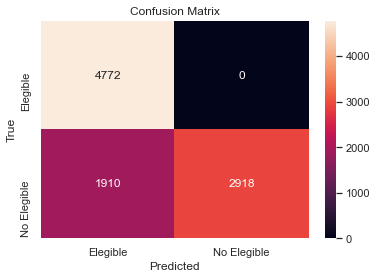

In [75]:
cm = confusion_matrix(y_train, y_pred_train)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Elegible', 'No Elegible']); ax.yaxis.set_ticklabels(['Elegible', 'No Elegible']);

[[1125  103]
 [ 710  462]]


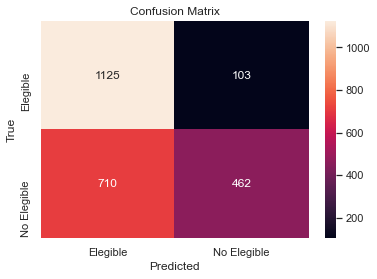

In [76]:
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Elegible', 'No Elegible']); ax.yaxis.set_ticklabels(['Elegible', 'No Elegible']);

##### 6.2.3.2. Para k = 5

In [77]:
modelo_knn = KNeighborsClassifier(n_neighbors=5)
modelo_knn = modelo_knn.fit(x_train, y_train)
y_pred_train = modelo_knn.predict(x_train)
y_pred_test = modelo_knn.predict(x_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.77
Exactitud sobre test: 0.68


[[4309  463]
 [1758 3070]]


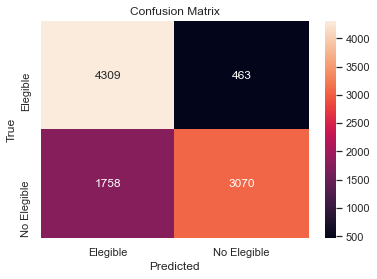

In [78]:
cm = confusion_matrix(y_train, y_pred_train)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Elegible', 'No Elegible']); ax.yaxis.set_ticklabels(['Elegible', 'No Elegible']);

[[1054  174]
 [ 588  584]]


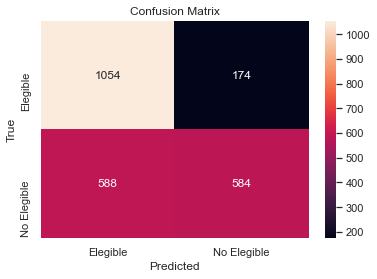

In [79]:
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Elegible', 'No Elegible']); ax.yaxis.set_ticklabels(['Elegible', 'No Elegible']);

#### 6.2.4. Conclusion del modelo

Una vez realizado el calculo de los hiperparámetros, y la revision de otros modelos, vemos que a pesar que hay un sobreajuste el mejor modelo sigue siendo el encontrado por el gridserach, pues es el que da mejores resultados para los datos nuevos (de prueba), entonces vemos que el mejor módelo es el que tiene los siguientes parametros:

<code>mejor_modelo={'n_neighbors': 1, 'p': 1}</code>

Lo que quiere decir que se basa en los x vecinos más cercanos para determinar el grupo al que pertenece un elemento.

Al aplicar el modelo encontrado sobre el conjunto de datos de entrenamiento y de prueba se obtienen los siguientes resultados:

In [66]:
# Obtener el mejor modelo.
modelo_final = modelo_Knn.best_estimator_
# Se prueba el modelo encontrado
y_pred_train = modelo_final.predict(x_train)
y_pred_test = modelo_final.predict(x_test)

In [67]:
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_test))

Exactitud sobre entrenamiento: 1.00
Exactitud sobre test: 0.70


[[4771    1]
 [   0 4828]]


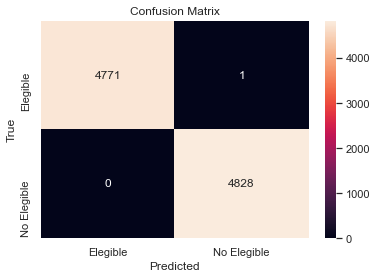

In [68]:
cm = confusion_matrix(y_train, y_pred_train)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Elegible', 'No Elegible']); ax.yaxis.set_ticklabels(['Elegible', 'No Elegible']);

Duepués de entrear el modelo y establecer los mejores hiperparamétros del mismo, vemos que este tiene una exactitud sobre el conjunto de datos de entrenamiento de practicamente el 100%, lo que indica que el modelo 

[[976 252]
 [470 702]]


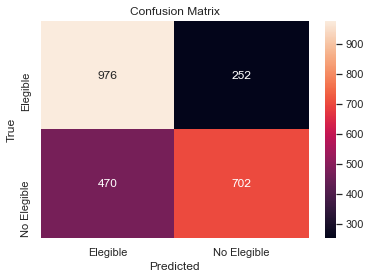

In [69]:
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Elegible', 'No Elegible']); ax.yaxis.set_ticklabels(['Elegible', 'No Elegible']);

Después de entrear el modelo y establecer los mejores hiperparamétros del mismo, vemos que este tiene una exactitud sobre el conjunto de datos de entrenamiento de practicamente el 100%, lo que indica que el modelo aprendió casi a la perfección el conjunto de datos sobre el que fue entrenado. Una vez se tiene entrenado el modelo, se procede a probarlo con la partición de los datos correspondiente, en general, se tiene una exactitud aceptable del 70%. Sin embargo, como se ve en la matriz mostrada anteriormente, la mayor parte de los datos predecidos erroneamente son lo que se consideran falsos-positivos, teniendo que la mayor parte de estos errores dan como elegibles a pacientes que en realidad no lo son.

### 6.3. Support Vector Machines

Se puede utilizar una SVM siempre y cuando se tengan exactamente dos clases. En esta situación se observan estas dos clases en la forma de "incluido" y "excluido", por lo que es ideal. Una SVM funciona de tal manera que encuentra el mejor "hiper-plano" que separa todos los datos que pertenecen a una clase de todos aquellos que no. Funciona por medio de vectores, por lo que es necesario transformar los datos en texto a valores de este tipo. En especifico para problemas con texto, que tienen una gran cantidad de rasgos diferentes, es recomendable utilizar una SVM de kernel lineal, lo que quiere decir que el hiper-plano que se utilizará para separar los datos es una línea recta.

Las ventajas de utilizar una SVM lineal incluyen la velocidad de entrenamiento y el hecho de que el único parámetro que se debe optimizar es la C-regularización. Además, cuando se comparan con otros algoritmos de clasificación, como redes neuronales, tienden a ser más rápidos y a tener mejores resultados cuando la cantidad de datos es relativamente pequeña (No pasa de los 20,000). Teniendo en cuenta que se está trabajando con 12,000 datos, una SVM lineal podría ser la forma ideal de clasificación para este problema.

Se comienza por revisar las tres opciones de datos dispobibles con diferentes valores de C, para encontrar tanto la opción correcta de datos para utilizar como el mejor valor de C para esta. Para esto, le damos mayor prioridad a un recall alto que a una precisión alta, por lo que calculamos el valor f beta con un valor de beta igual a 2, y se encuentra el mayor valor de cada lista creada, escogiendose el mayor entre estos dos como el mejor modelo posible.

In [47]:
np.random.seed(117)
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC  
from sklearn.metrics import precision_recall_fscore_support as precrec
from sklearn.metrics import fbeta_score
from sklearn.metrics import plot_confusion_matrix, classification_report
study_train, study_test, y_train_s, y_test_s = train_test_split(X_data_study, y_data, test_size=0.2, random_state=117)
cancer_train, cancer_test, y_train_c, y_test_c = train_test_split(X_data_cancer, y_data, test_size=0.2, random_state=117)
both_train, both_test, y_train_b, y_test_b = train_test_split(X_data_junto, y_data, test_size=0.2, random_state=117)
f_s = []
f_c = []
f_b = []
for i in range(1,15):
    svm_c = LinearSVC(C=i, random_state=117)
    svm_s = LinearSVC(C=i, random_state=117)
    svm_b = LinearSVC(C=i, random_state=117)
    svm_c.fit(cancer_train, y_train_c)
    svm_s.fit(study_train, y_train_s)
    svm_b.fit(both_train, y_train_b)
    pred_svm_c = svm_c.predict(cancer_test)
    pred_svm_s = svm_s.predict(study_test)
    pred_svm_b = svm_b.predict(both_test)
    f_c.append(fbeta_score(y_test_c, pred_svm_c, average='binary', beta=2))
    f_s.append(fbeta_score(y_test_s, pred_svm_s, average='binary', beta=2))
    f_b.append(fbeta_score(y_test_b, pred_svm_b, average='binary', beta=2))

In [48]:
print(max(f_c))
print(max(f_s))
print(max(f_b))

0.7651849338310145
0.5778477864367435
0.7533434907736585


In [49]:
print(np.argmax(f_c))

0


De los hiperparámetros que se pueden cambiar para una SVM en sklearn.svm.LinearSVC, el único que tienen un efecto en nuestro problema es la C-regularización. Teniendo este hecho en cuenta, se llevó a cabo un experimento para encontrar el mejor valor de C posible para los datos que se tienen. Para entender cuál es el mejor valor para la C-regularización, es necesario entender lo que este hiperparámetro es en general, por lo que se dará una corta explicación a continuación.

#### C-regularización}

En una SVM se intenta encontrar dos cosas: un hiper-plano que separe instancias de la forma más correcta posible, y un hiper-plano con el más alto margen mínimo posible. Estos dos factores, sin embargo, no siempre van de la mano, y por esta razón existe la C-regularización. Esta le indica al algoritmo que tan importante es obtener las instancias de la forma más correcta posible, en comparación con la importancia del margen. Entre mayor sea el valor de C, más importancia se le dará a clasificar las instancias de la forma más correcta posible.

Hay casos en los que clasificar las instancias de la forma más correcta posible puede ser contraproducente, reduciendo la posibilidad de que nuevos datos sean clasificados correctamente si no son extremadamente parecidos a los datos que se han obtenido anteriormente. Esto quiere decir que un C alto es ideal si se espera que los valores nuevos sean muy similares a los que ya se han obtenido, mientras que un C bajo es ideal si se espera obtener nuevos datos que no sean extremadamente similares a los ya obtenidos pero que requieran ser clasificados junto con ellos. 

Para este caso especifico, la métrica principal a utilizar será el recall que se consiga con cada valor de C, ya que este nos ayuda a asegurar que pacientes que clasifican para el tratamiento lo obtengan, hasta si esto quiere decir que algunos que no clasifican pasan también. Esta forma de medición indica que se puede esperar que un valor bajo de C-regularización sea el indicado. De forma secundaria, también se busca un valor lo más alto posible de precisión, ya que también es importante asegurar que los pacientes incluidos no hagan parte del grupo que debía ser excluido.\\\\

Teniendo en cuenta los factores anteriormente mencionados, se llevó a cabo un procedimiento de optimización del valor de C, buscando maximizar el valor de f-$\beta$, donde beta tiene un valor de 2, para conseguir así el modelo que mejor cumpla con las expectativas del negocio. También se llevó a cabo el procedimiento tres veces distintas, una con los datos del cáncer, una con los datos del estudio, y una con todos los datos, para así escoger la opción adecuada.

De esta información se obtiene que el mejor modelo es un SVC lineal con un valor de C igual a 1, y que utiliza los datos del cancer exclusivamente, aunque los datos de tanto el cancer como el estudio también se podrían utilizar. Para el modelo elegido, se revisan también los valores especificos de precisión y recall, además de crearse la matriz de confusión, a continuación.

In [50]:
svm = LinearSVC(random_state=117)
svm.fit(cancer_train, y_train_c)
pred_svm = svm.predict(cancer_test)
pred_train_svm = svm.predict(cancer_train)
print(precrec(pred_svm, y_test_c, average='binary'))
print(precrec(pred_train_svm, y_train_c, average='binary'))

(0.7637595258255715, 0.770940170940171, 0.767333049766057, None)
(0.9416891471259597, 0.9462051709758131, 0.9439417576703069, None)


Resultados de predicciones con datos de entrenamiento
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      4781
           1       0.95      0.94      0.94      4819

    accuracy                           0.94      9600
   macro avg       0.94      0.94      0.94      9600
weighted avg       0.94      0.94      0.94      9600



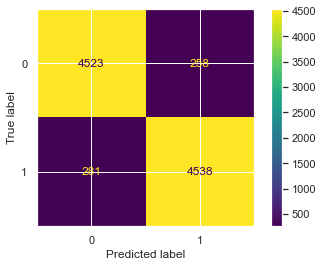

In [51]:
print("Resultados de predicciones con datos de entrenamiento")
print(classification_report(y_train_c, pred_train_svm))
plot_confusion_matrix(svm, cancer_train, y_train_c)

Resultados de predicciones con datos de prueba
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1219
           1       0.77      0.76      0.77      1181

    accuracy                           0.77      2400
   macro avg       0.77      0.77      0.77      2400
weighted avg       0.77      0.77      0.77      2400



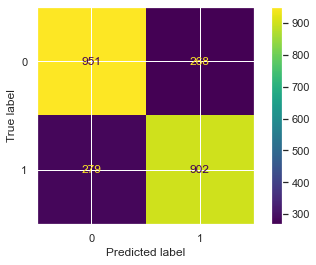

In [52]:
print("Resultados de predicciones con datos de prueba")
print(classification_report(y_test_c, pred_svm))
plot_confusion_matrix(svm, cancer_test, y_test_c)

In [53]:
np.random.seed(117)
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as precrec
from sklearn.metrics import fbeta_score
from sklearn.metrics import plot_confusion_matrix, classification_report
study_train, study_test, y_train_s, y_test_s = train_test_split(X_data_study, y_data, test_size=0.2, random_state=117)
cancer_train, cancer_test, y_train_c, y_test_c = train_test_split(X_data_cancer, y_data, test_size=0.2, random_state=117)
both_train, both_test, y_train_b, y_test_b = train_test_split(X_data_junto, y_data, test_size=0.2, random_state=117)
f_s = []
f_c = []
f_b = []
for i in range(1,15):
    svm_c = LinearSVC(C=i, random_state=117)
    svm_s = LinearSVC(C=i, random_state=117)
    svm_b = LinearSVC(C=i, random_state=117)
    svm_c.fit(cancer_train, y_train_c)
    svm_s.fit(study_train, y_train_s)
    svm_b.fit(both_train, y_train_b)
    pred_svm_c = svm_c.predict(cancer_test)
    pred_svm_s = svm_s.predict(study_test)
    pred_svm_b = svm_b.predict(both_test)
    f_c.append(fbeta_score(y_test_c, pred_svm_c, average='binary', beta=2))
    f_s.append(fbeta_score(y_test_s, pred_svm_s, average='binary', beta=2))
    f_b.append(fbeta_score(y_test_b, pred_svm_b, average='binary', beta=2))

In [54]:
print(max(f_c))
print(max(f_s))
print(max(f_b))

0.7651849338310145
0.5778477864367435
0.7533434907736585


Estos valores nos demuestran que la mejor opción para SVM es utilizar los datos exclusivamente del cáncer, aunque utilizar ambos datos tiene un valor casi igual. Al buscar cuál valor de C obtuvo el mayor resultado de f-$\beta$, se descubre que este pasa cuando C=1, lo que concuerda con la hipótesis inicial de que el valor sería bajo para reducir la posibilidad de que personas que cumplan con los prerrequisitos para obtener tratamiento no lo obtengan, inclusive si unas pocas más de las que no cumplen terminen obteniéndolo.

### 6.4. Logistic Regression

La regresión logística es uno de los algoritmos de aprendizaje automático más simples y comúnmente utilizados para la clasificación de dos clases. Es fácil de implementar y se puede utilizar como base para cualquier problema de clasificación binaria.

La regresión logística es un método estadístico para predecir clases binarias. La variable de resultado o objetivo es de naturaleza dicotómica. Dicotómico significa que solo hay dos clases posibles. Es un caso especial de regresión lineal donde la variable objetivo es de naturaleza categórica. Utiliza un registro de probabilidades como variable dependiente. La regresión logística predice la probabilidad de ocurrencia de un evento binario utilizando una función sigmoide.

Para esto, sabemos que la Regresión logística es util pues, comparado con la regresión lineal, que brinda una salida continua, la regresión logística proporciona una salida constante, y para este caso, necesitamos hacer un modelo predictivo que determine si un pacientes es o no elegible para el tratamiento de cancer especifico.

#### 6.4.1. Modelo Ingenuo

A continuación se usan todos los datos, y se hace una primera predicción de un modelo ingenuo.

In [70]:
x_train, x_test, y_train, y_test = train_test_split(df_bow_sklearn.drop(['label'],axis=1), df_bow_sklearn['label'], test_size=0.2, random_state=0)

In [71]:
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(x_train,y_train)
y_pred_train = lr.predict(x_train)
y_pred_test = lr.predict(x_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.93
Exactitud sobre test: 0.79


#### 6.4.2. Busqueda de hiperparametros

Con la información anterior, nos podemos dar cuenta que la regresión logística es un modelo que nos puede dar resultados con mejor exactitud que los modelos anteriores, por lo tanto, para generar un mejor modelo, se porpone hacer una búsqueda de los mejores hiperparámetros, para así poder encontrar el mejor modelo de regresión logística.

In [72]:
model = LogisticRegression()
solvers = ['liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.781458 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [73]:
lr_final = grid_search.best_estimator_
lr_final

LogisticRegression(C=0.1, solver='liblinear')

In [74]:
y_pred_train = lr_final.predict(x_train)
y_pred_test = lr_final.predict(x_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.86
Exactitud sobre test: 0.79


#### 6.4.3. Evaluación del modelo

Con este resultado, se encontró que el mejor modelo es:

<code>LogisticRegression('C': 0.1, 'penalty': 'l2', 'solver': 'liblinear')</code>

Ahora bien, se mirarán los resultados entonces de la matriz de confusión, para poder hacer un mejor análisis del modelo.

Matriz para datos de ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4772
           1       0.87      0.86      0.87      4828

    accuracy                           0.86      9600
   macro avg       0.86      0.86      0.86      9600
weighted avg       0.86      0.86      0.86      9600

[[4124  648]
 [ 654 4174]]


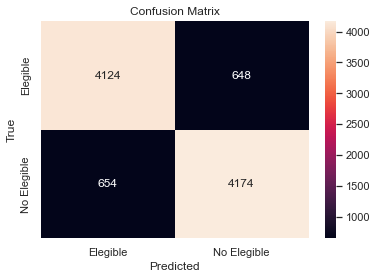

In [76]:
print("Matriz para datos de ENTRENAMIENTO")
print(classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Elegible', 'No Elegible']); ax.yaxis.set_ticklabels(['Elegible', 'No Elegible']);

Como se puede observar, la regresión es buena, pues tiene una exactitud de 0.86. En cuanto a la precision de la regresión de cada una de las clases se puede decir que el modelo lo hace correctamente para los datos de entrenamiento para las dos clases, pues la precision es de 0.86 y 0.87, respectivamente. Es decir que los datos que clasifica como verdaderos positivos respecto a el total de datos que clasifica como positivos es bastante bueno para los papcientes que no son elegibles, y para aquellos que lo son. Adicionalmente la sensibilidad de aquellos datos que clasifica como verdaderos con respecto al total que son verdaderos es buena para ambas clases, pues tiene un recall de 0.86 en ambas..

Sin embargo, los datos que mas nos interesa ver es como se maneja el modelo son los datos de prueba, pues queremos ver que el modelo funcione aun cuando no conoce los datos con anterioridad, esto se muestra a continuacion.

Matriz para datos de PRUEBA
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1228
           1       0.78      0.79      0.78      1172

    accuracy                           0.79      2400
   macro avg       0.79      0.79      0.79      2400
weighted avg       0.79      0.79      0.79      2400

[[962 266]
 [248 924]]


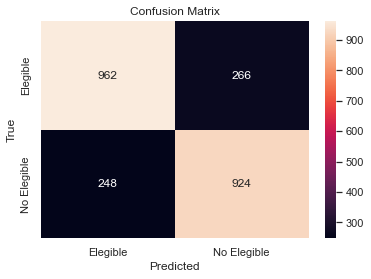

In [77]:
print("Matriz para datos de PRUEBA")
print(classification_report(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Elegible', 'No Elegible']); ax.yaxis.set_ticklabels(['Elegible', 'No Elegible']);

Como se puede observar, la regresión es buena, pues tiene una exactitud de 0.79, y es de hecho la mejor entre todos los modelos realizados. En cuanto a la precision de la regresión de cada una de las clases se puede decir que el modelo lo hace correctamente para los datos de entrenamiento para las dos clases, pues la precision es de 0.80 y 0.78, ligeramente mejor para la clase 0 que para la 1. Es decir que los datos que clasifica como verdaderos positivos respecto a el total de datos que clasifica como positivos es bastante bueno para los papcientes que no son elegibles, y para aquellos que lo son. Adicionalmente la sensibilidad de aquellos datos que clasifica como verdaderos con respecto al total que son verdaderos es buena para ambas clases, pues tiene un recall de 0.78 y 0.79, respectivamente.

## 7. Resultados

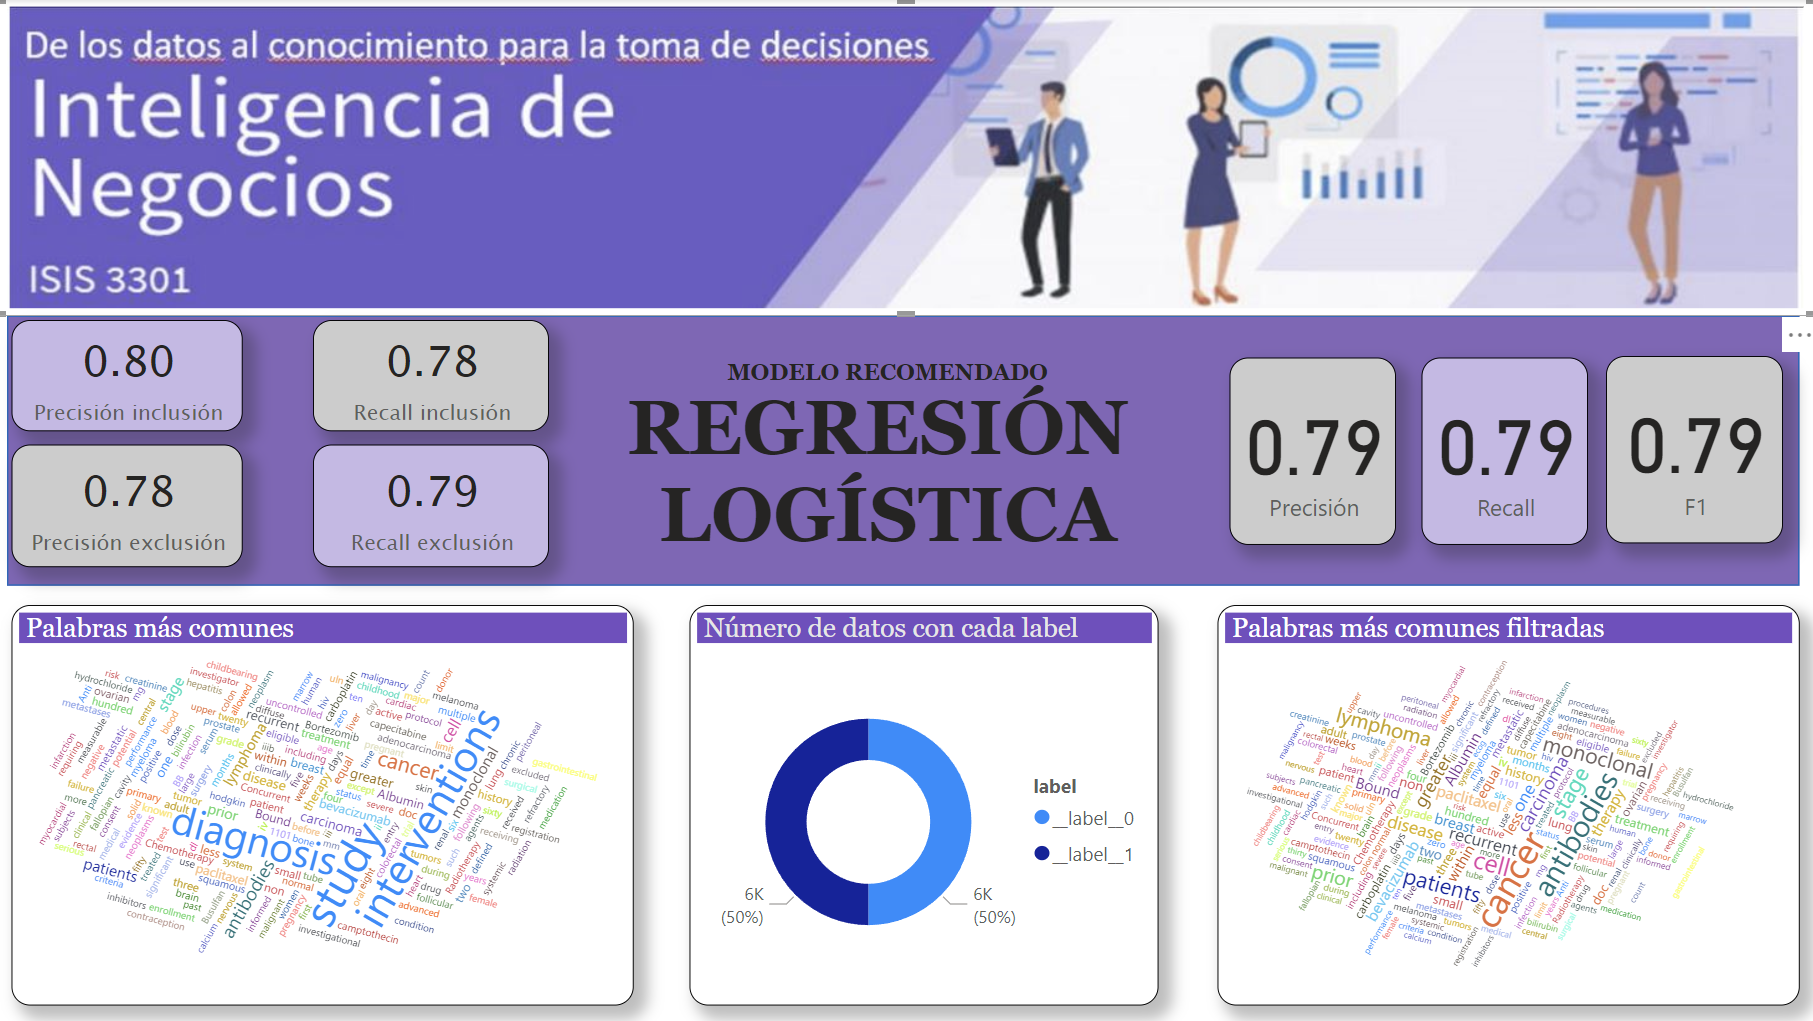

## 8. Conclusiones

- Finalmente se puede concluir que el modelo que hace la mejor predicción de la elegibilidad de un paciente dado el diagnostico es la Regresión Logística.
- Se observa que la precisión y el recall podrían incrementar si se llevara a cabo una estandarización en la metodología de escribir los informes médicos recibidos. Las nubes de palabras dan información acerca de las palabras cruciales a la hora de llevar a cabo la separación entre cada categoría, por lo que el cliente puede estandarizarlo hasta el punto que le sea conveniente.
- Sin importar la precisión que se encuentre en modelos como estos, estos siempre deberán ser utilizados como apoyo a la toma de decisiones médicas, no como un reemplazo, ya que decisiones tan cruciales como la de quién recibe tratamientos que podrían salvar su vida y quién no siempre deben tener un filtro humano en algún momento. Estas herramientas ayudarán a tomar la decisión más velozmente, pero no la harán por el médico.
- Se podría llevar a cabo investigaciones más a fondo con otros modelos de clasificación para encontrar alguno que sirva mejor para el caso especifico del cliente, buscando primero un recall y luego una precisión mayores a los obtenidos en esta investigación. Sin embargo, teniendo en cuenta el costo computacional que algunos modelos tienen, esto podría terminar siendo contraproducente, ya que siempre será necesaria la revisión humana y los valores obtenidos ya son suficientes para cumplir con las necesidades del cliente.